In [193]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test
import numpy as np
from astropy.stats import sigma_clip
import pandas as pd

In [194]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [195]:
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

Write a function that computes the squared loss, and incorporatets the uncertainties on the measurements, dy

In [196]:
def squared_loss(x,y,dy,a,b):
    y_predict = np.empty(len(x))
    loss = np.empty(len(x))
    squared_loss = np.empty([len(a),len(b)])
    for na in range(len(a)):
        for nb in range(len(b)):
            for i in range(len(x)):
                y_predict[i] = a[na]*x[i]+b[nb]
                loss[i] = y_predict[i]-y[i]
            squared_loss[na,nb]=sum((loss/dy)**2)
    return squared_loss

Fit a line to full sample by evaluating this likelihood on a grid of a,b.

In [197]:
a = np.linspace(0,3, 100)
b = np.linspace(0,300,100)

In [198]:
square_loss = squared_loss(x,y,dy,a,b)

In [199]:
np.where(square_loss==square_loss.min())

(array([35]), array([71]))

In [200]:
print ('a=',a[35],'\nb=',b[71])

a= 1.0606060606060606 
b= 215.15151515151516


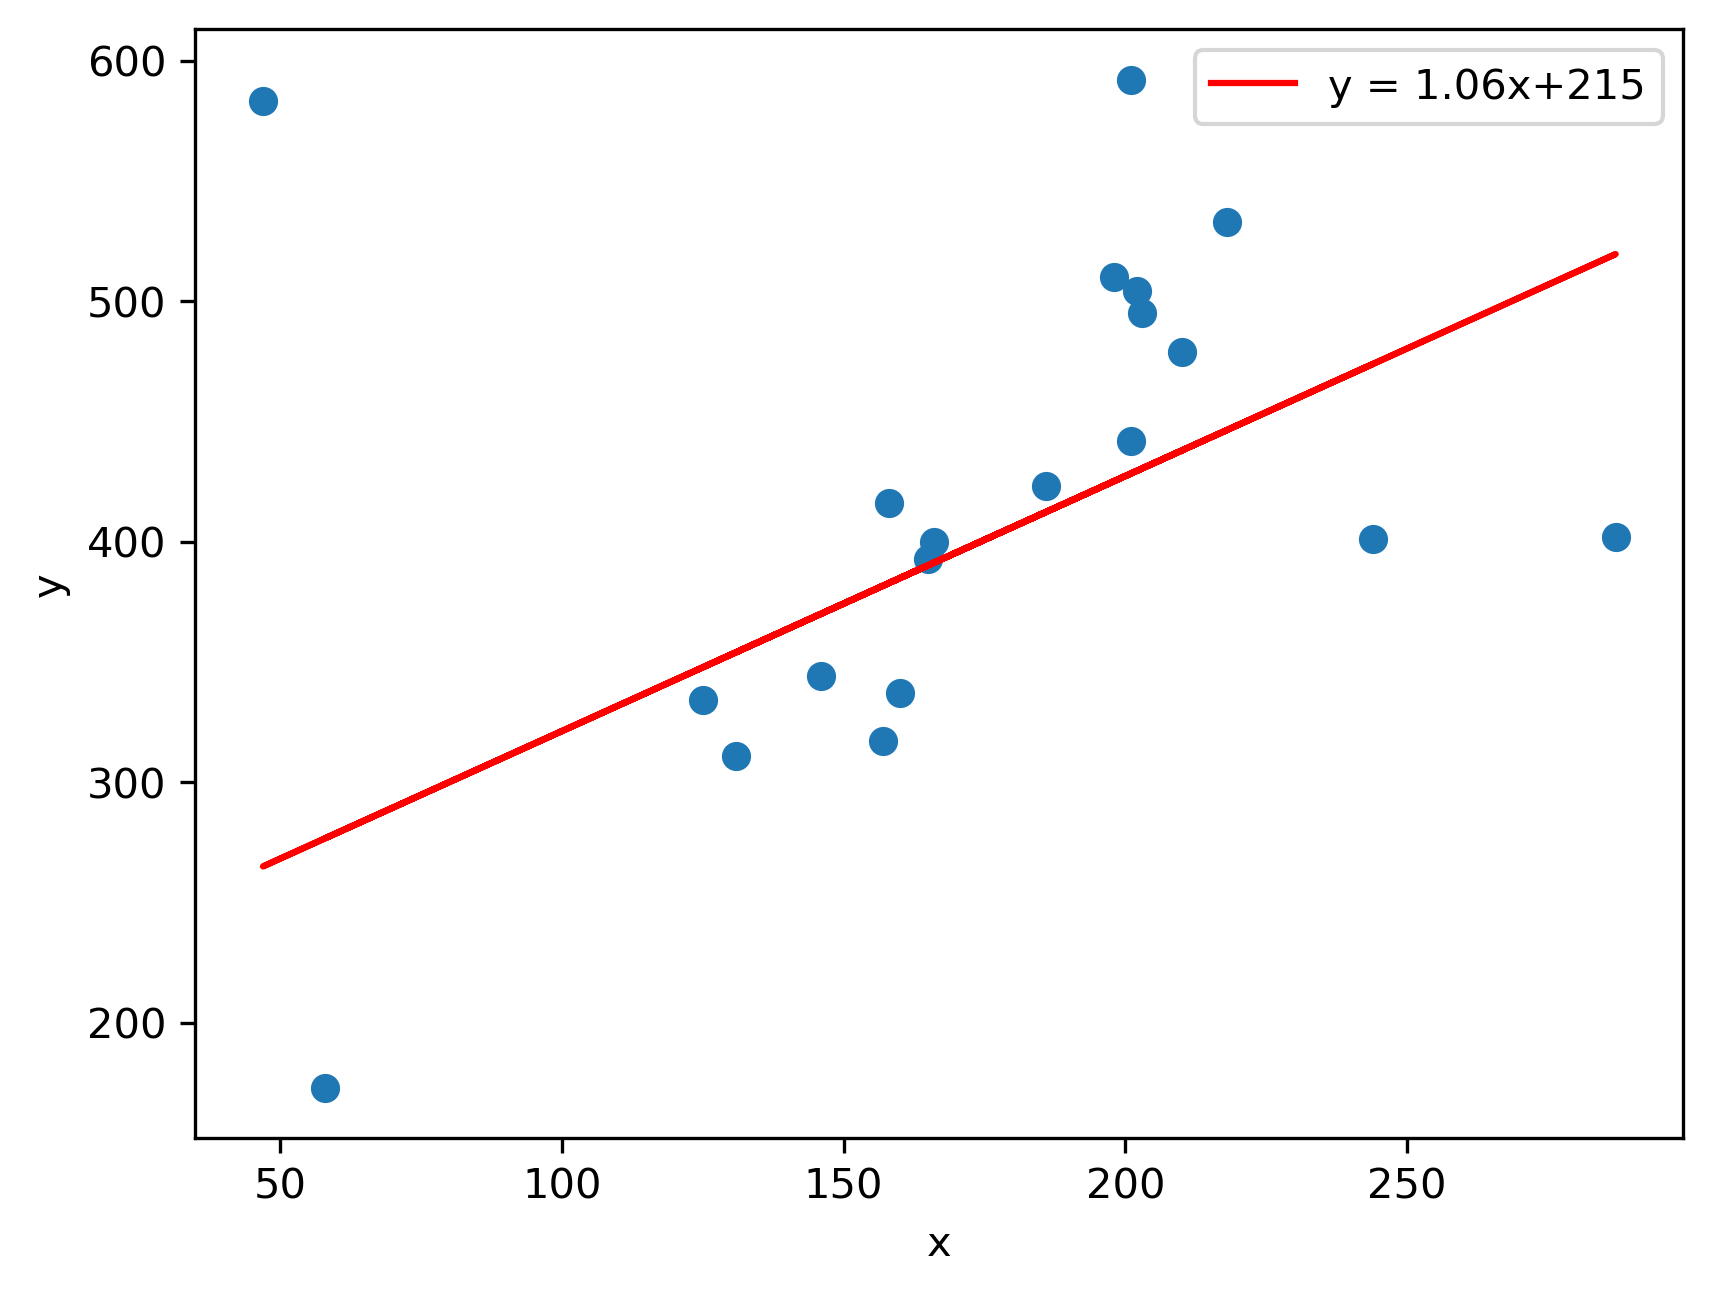

In [201]:
plt.scatter(x,y)
plt.plot(x,a[35]*x+b[71],label = 'y = 1.06x+215',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected

In [202]:
filtered_y = sigma_clip(y, sigma=2,maxiters=5)
filtered_x = sigma_clip(x, sigma=2,maxiters=5)
index_y = np.where(filtered_y.mask == False)[0]
index_x = np.where(filtered_x.mask == False)[0]
index = np.intersect1d(index_y,index_x)

In [203]:
square_loss_filtered = squared_loss(x[index],y[index],dy[index],a,b)

In [204]:
np.where(square_loss_filtered==square_loss_filtered.min())

(array([63]), array([28]))

In [205]:
print ('a=',a[63],'\nb=',b[28])

a= 1.9090909090909092 
b= 84.84848484848484


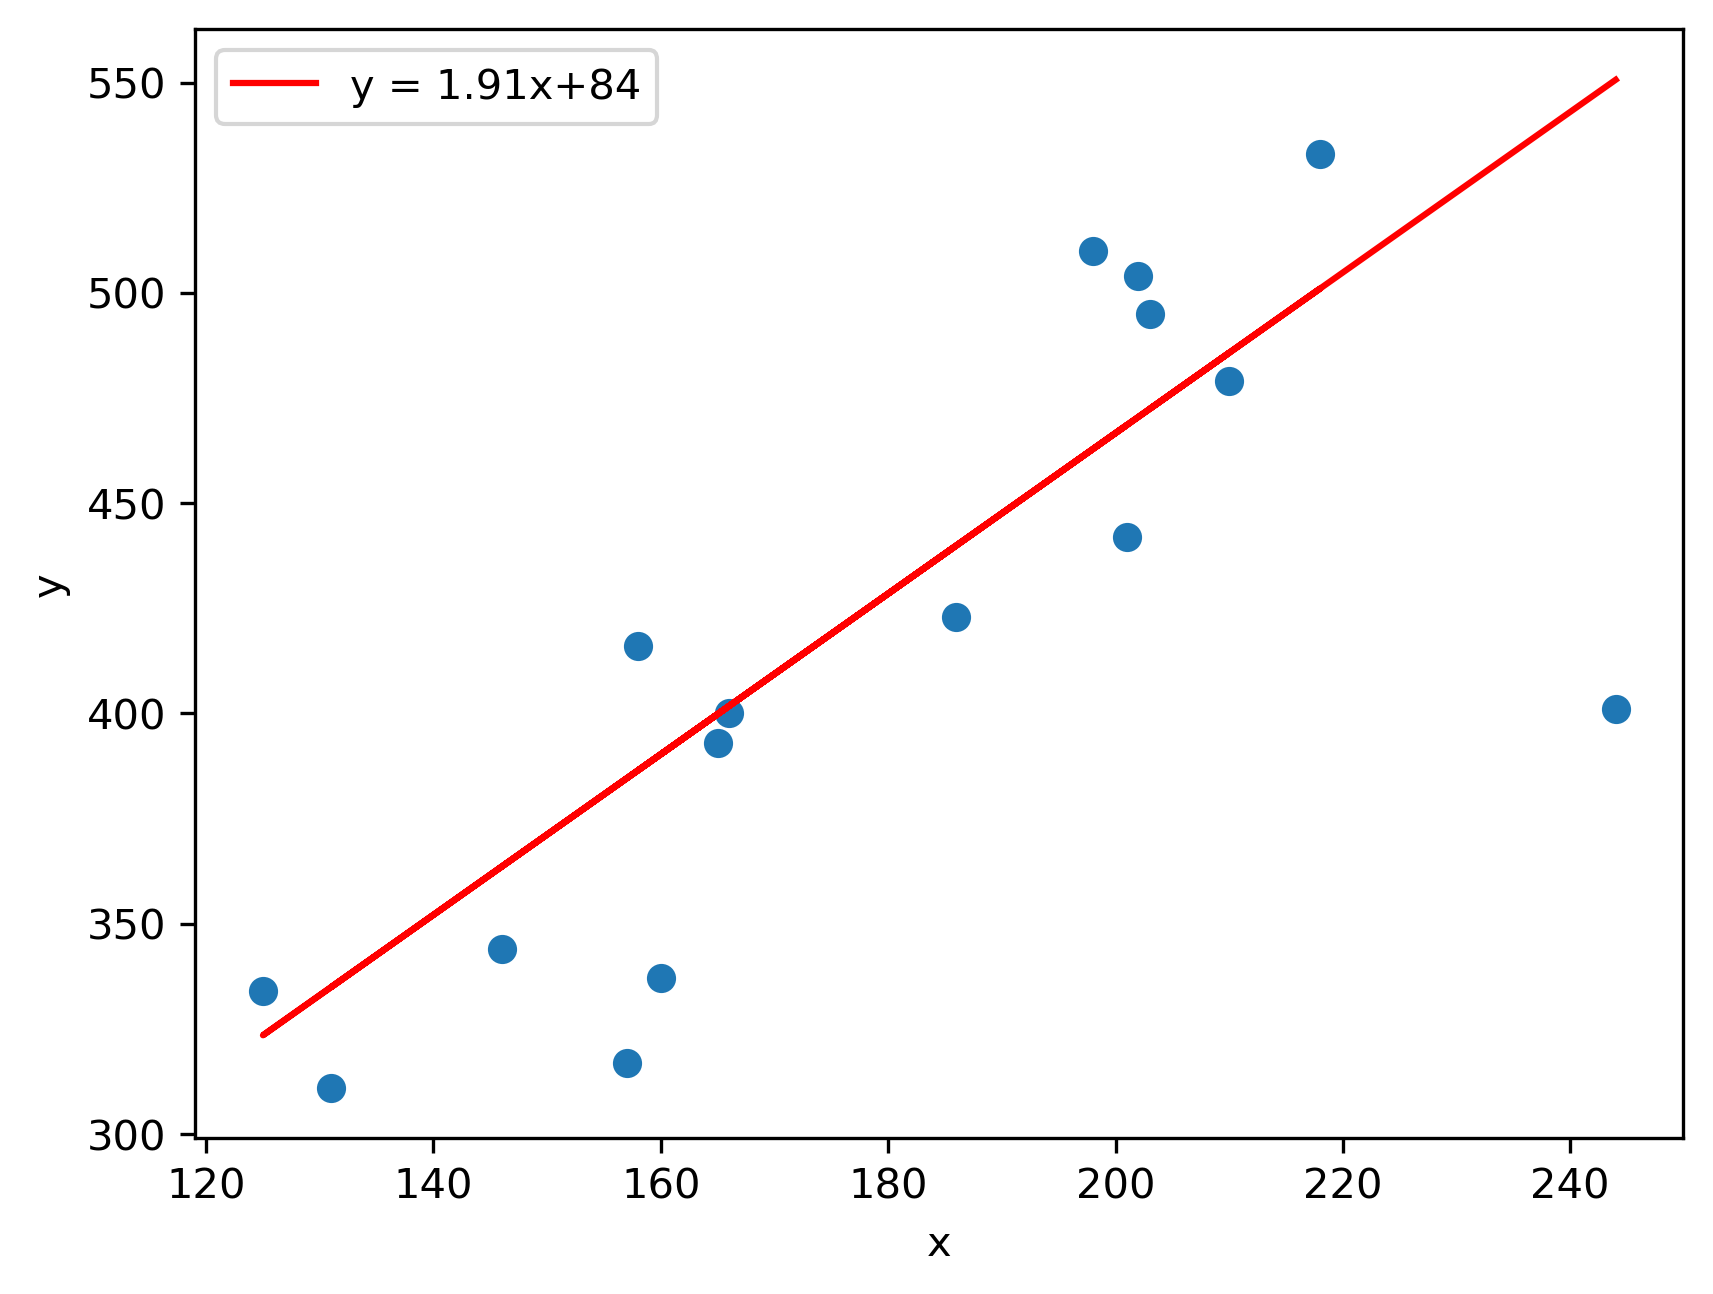

In [206]:
plt.scatter(x[index],y[index])
plt.plot(x[index],a[63]*x[index]+b[28],label = 'y = 1.91x+84',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

and make a QQ plot of the residuals

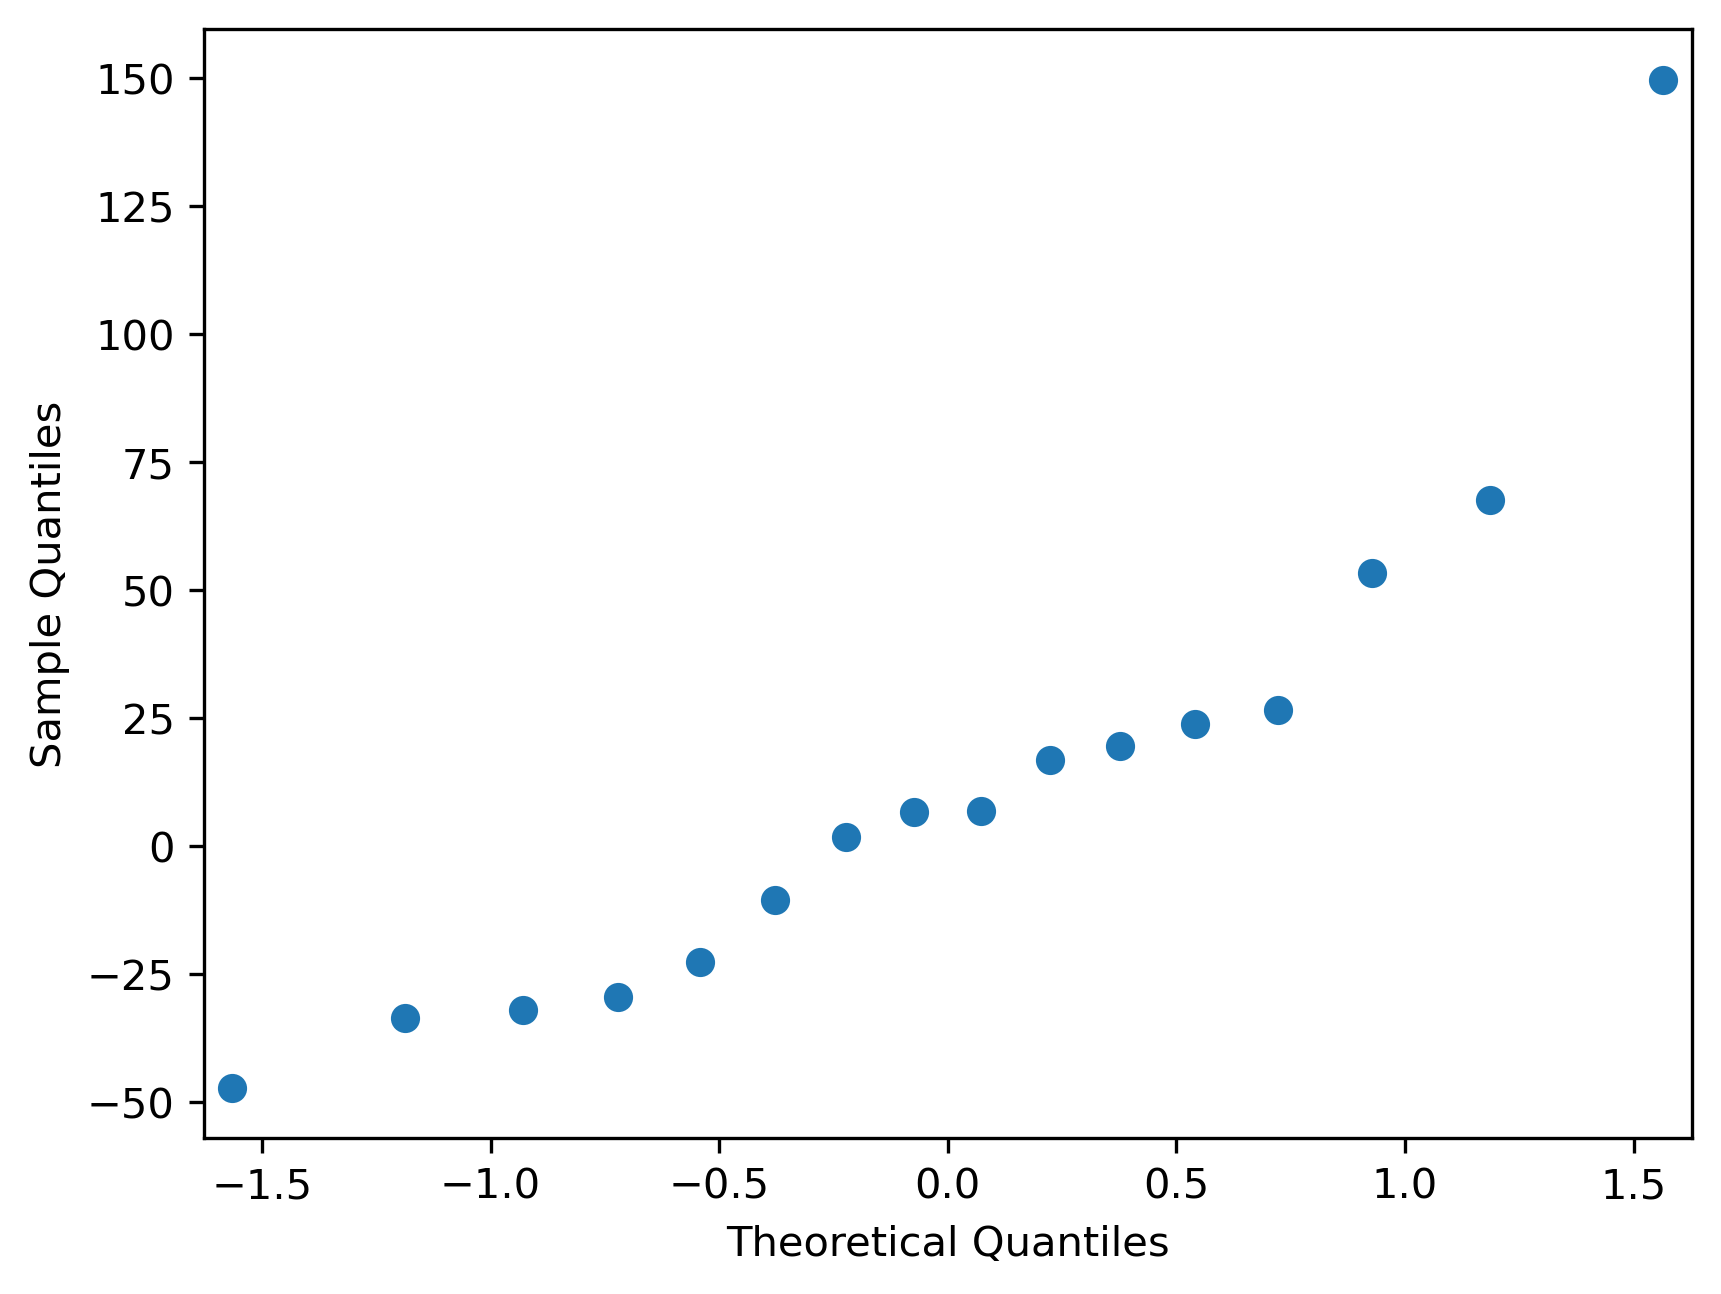

In [207]:
y_fit = a[63]*x[index]+b[28]
residual = y_fit-y[index]
sm.qqplot(residual)
plt.show()

Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties dy

In [208]:
def Huber_loss(params):
    a = params[0]
    b = params[1]
    loss = np.empty(len(x))
    for i in range(len(x)):
        y_predict = a*x[i]+b
        if abs(y_predict-y[i]) <= 4:
            loss[i] = 0.5*(y_predict-y[i])**2
        else:
            loss[i] = 4*(abs(y_predict-y[i])-2)
    Huber_loss = sum(loss)
    return Huber_loss

Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals

In [209]:
from scipy import optimize

In [210]:
minimum = optimize.fmin(Huber_loss,[2,100])
minimum

Optimization terminated successfully.
         Current function value: 5099.327392
         Iterations: 56
         Function evaluations: 107


array([  1.6151739 , 128.82690006])

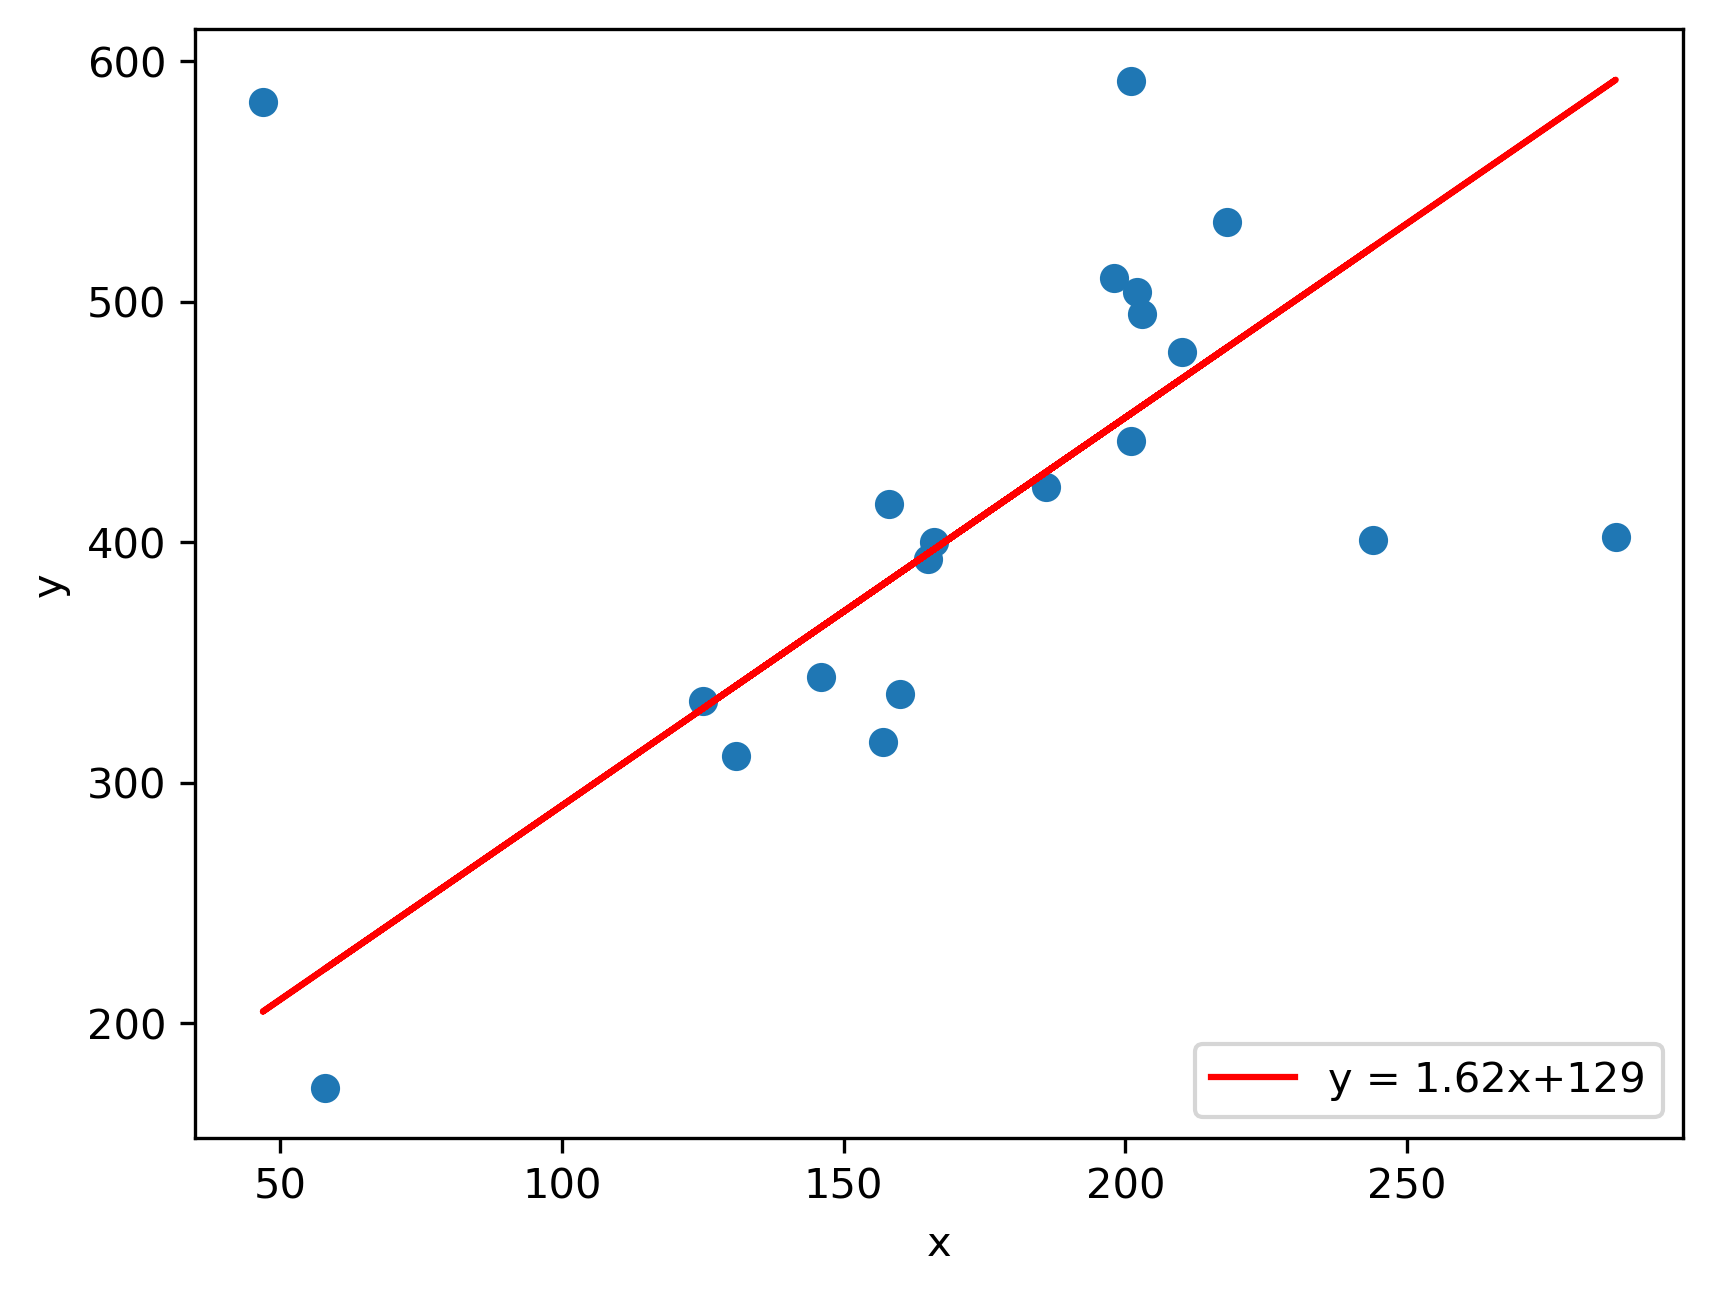

In [211]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],label = 'y = 1.62x+129',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

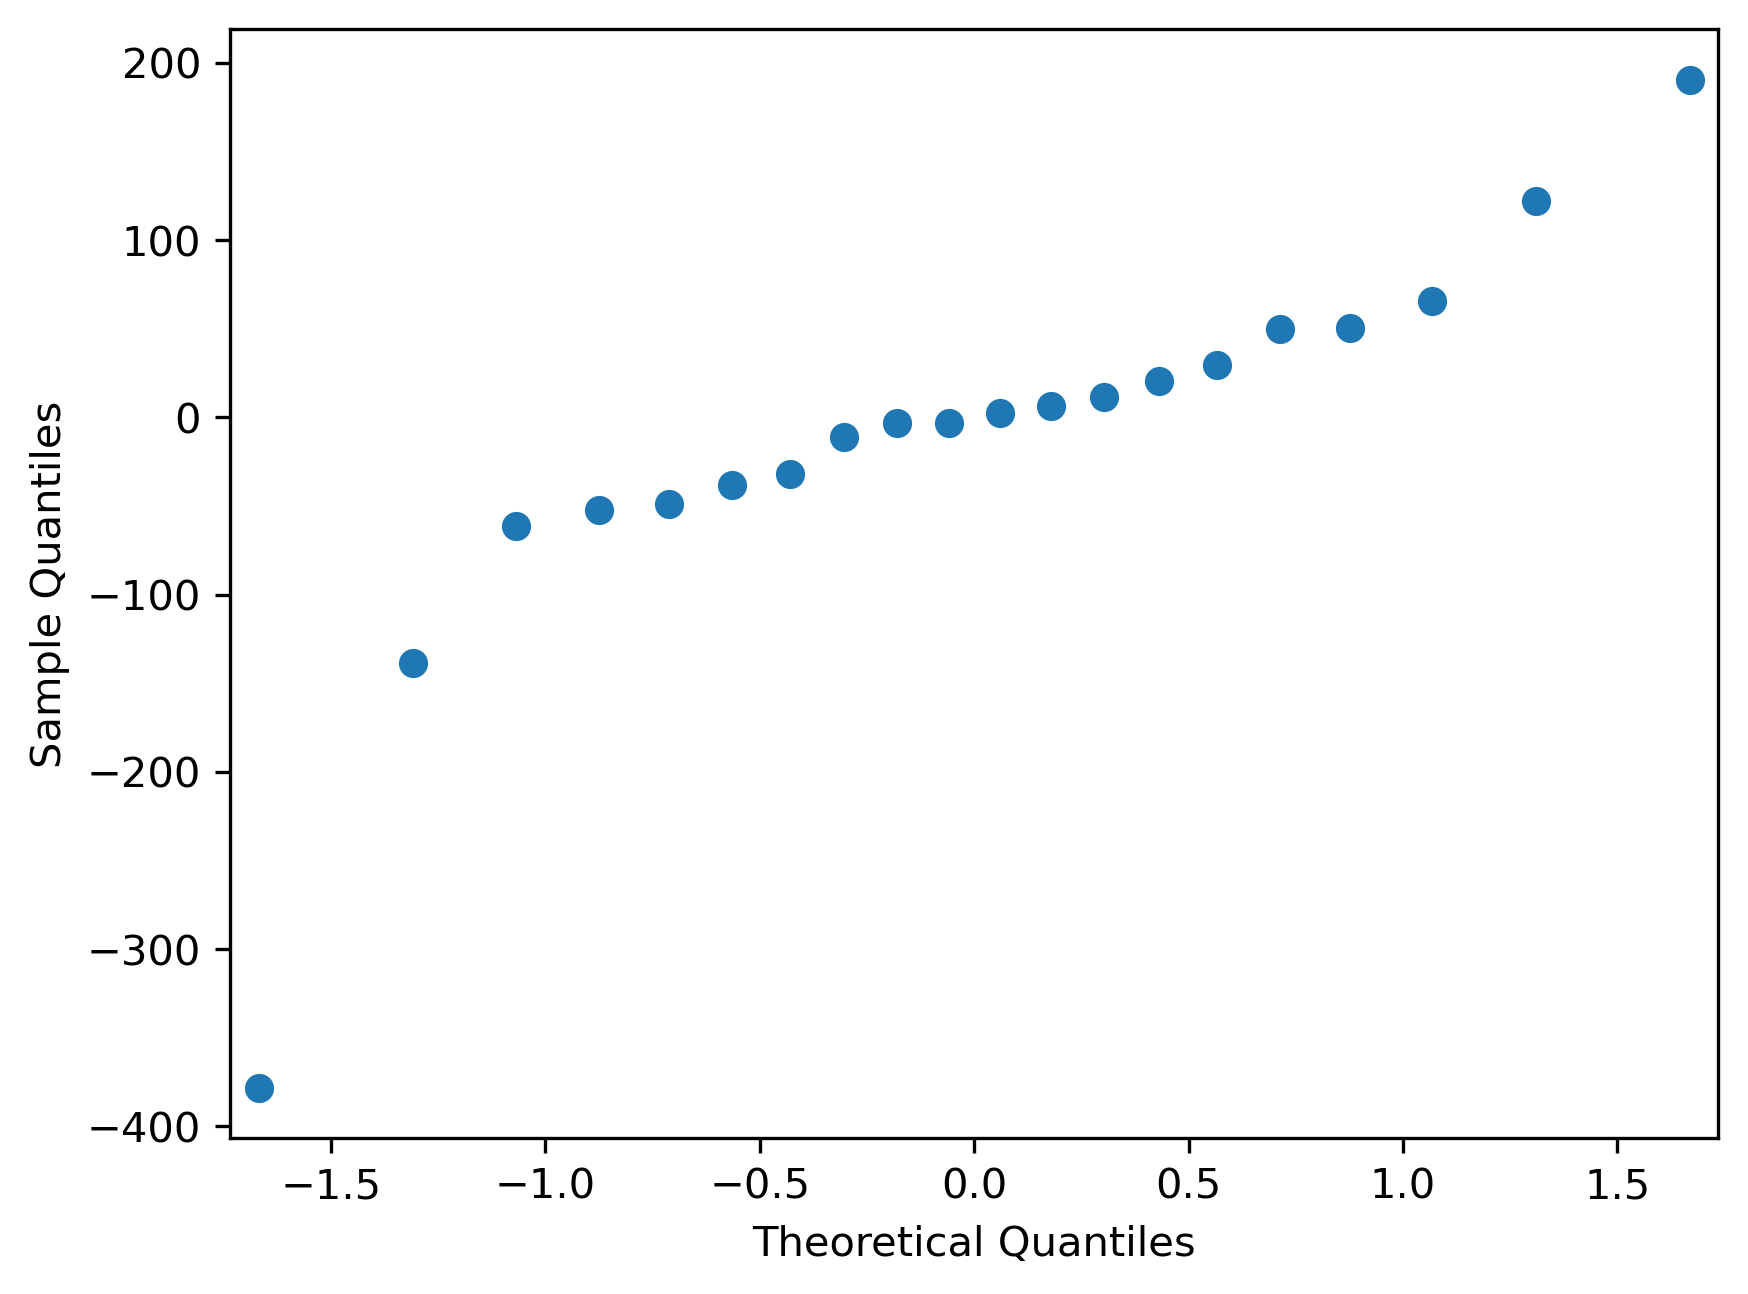

In [212]:
y_fit_huber = minimum[0]*x+minimum[1]
residual_huber = y_fit_huber-y
sm.qqplot(residual_huber)
plt.show()

Split the data into LMC and SMC, and then again by mode F and 1, and plot the W on the y-axis vs log(P1) on x. Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

In [213]:
data = pd.read_csv('~/astr596/ast596_2023_Spring/homework/01/Cepheids.csv')
data

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


In [214]:
LMC = data[data['Cloud']=='LMC']
SMC = data[data['Cloud']=='SMC']
LMC_f = LMC[LMC['Mode']=='F']
LMC_1 = LMC[LMC['Mode']=='1']
SMC_f = SMC[SMC['Mode']=='F']
SMC_1 = SMC[SMC['Mode']=='1']

In [238]:
y = np.array(LMC_f['W'])
x = np.array(LMC_f['logP1'])

In [239]:
minimum = optimize.fmin(Huber_loss,[-2,3])
minimum

Optimization terminated successfully.
         Current function value: 18.676754
         Iterations: 61
         Function evaluations: 120


array([-3.32588042, 15.89287458])

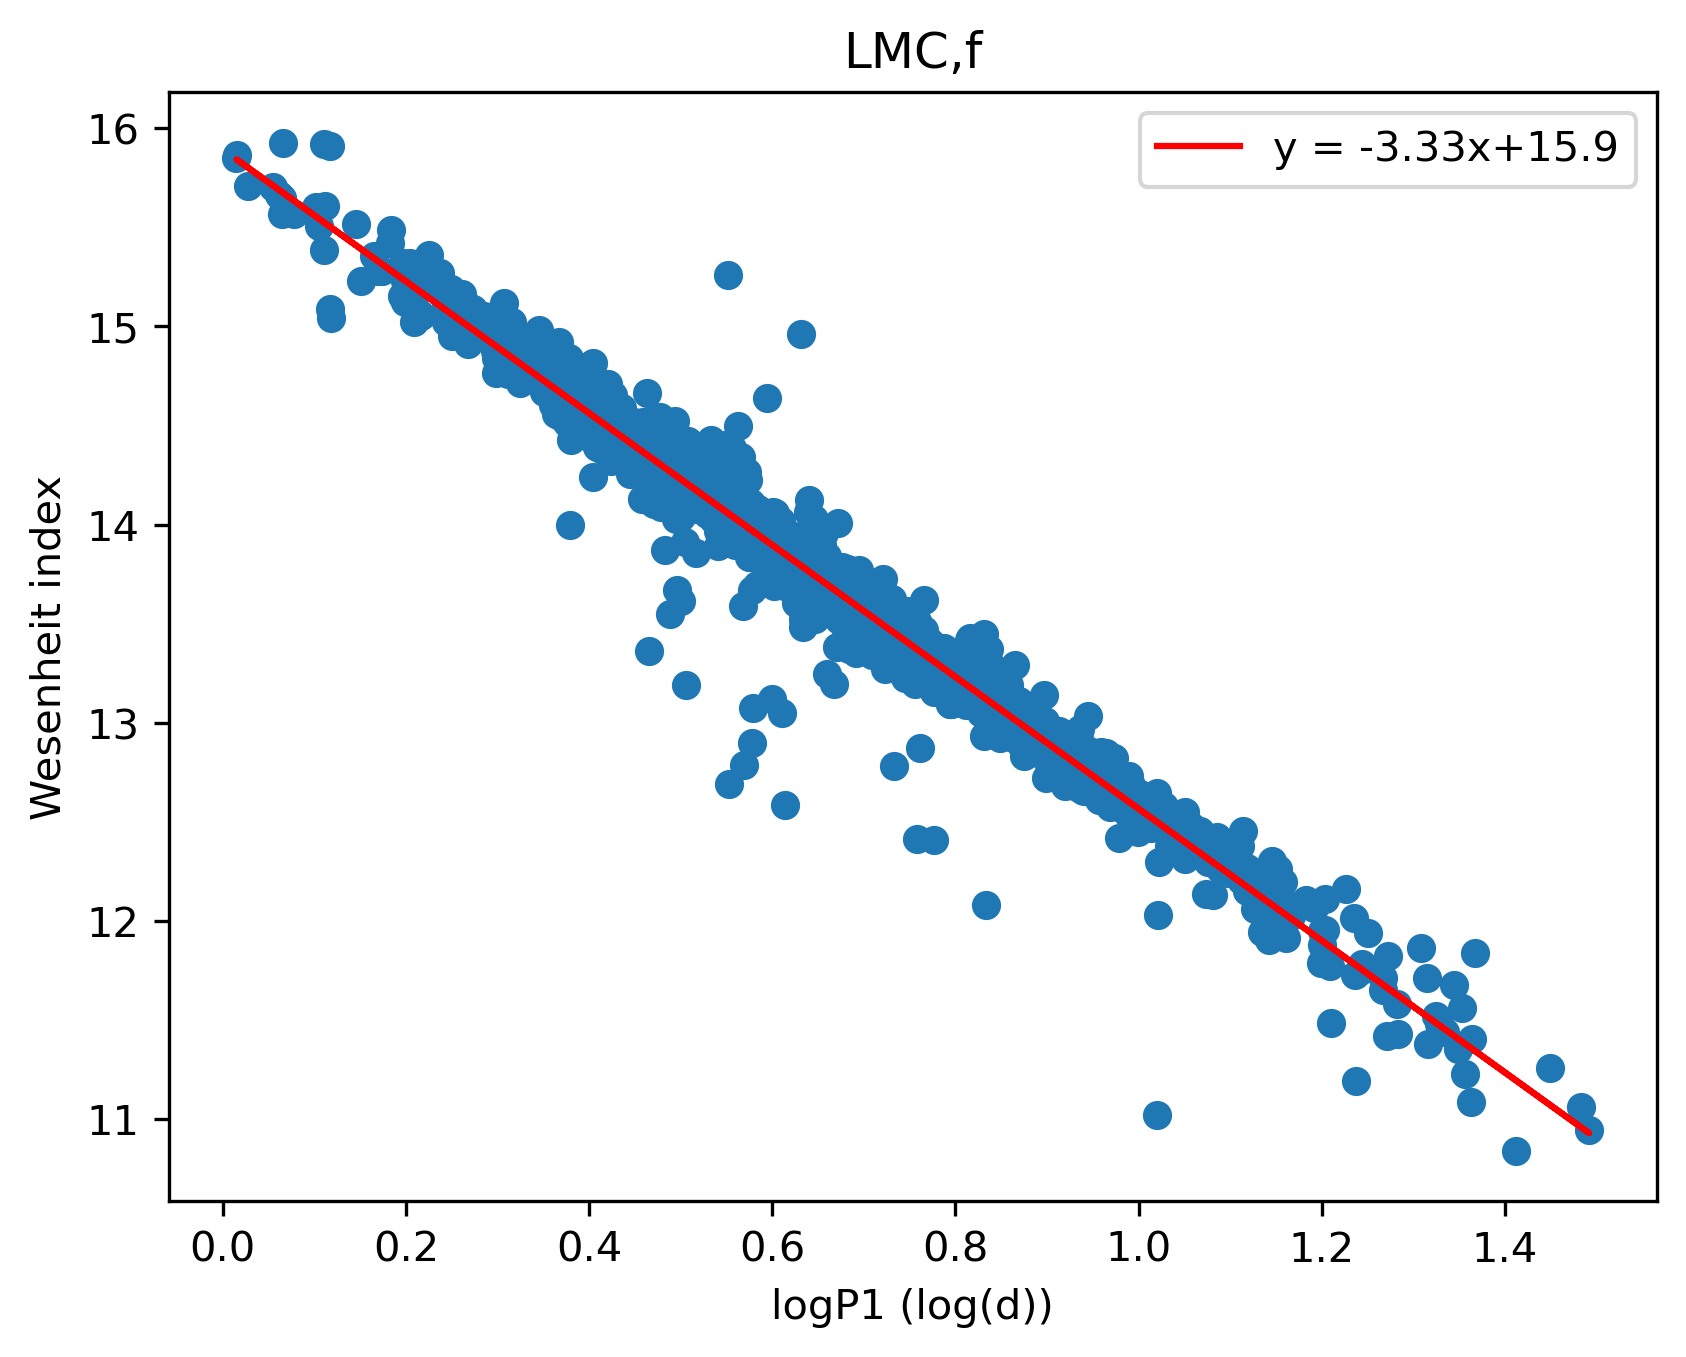

In [240]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],color = 'red',label = 'y = -3.33x+15.9')
plt.title('LMC,f')
plt.xlabel('logP1 (log(d))')
plt.ylabel('Wesenheit index')
plt.legend()
plt.show()

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

In [245]:
residuals = minimum[0]*x+minimum[1]-y

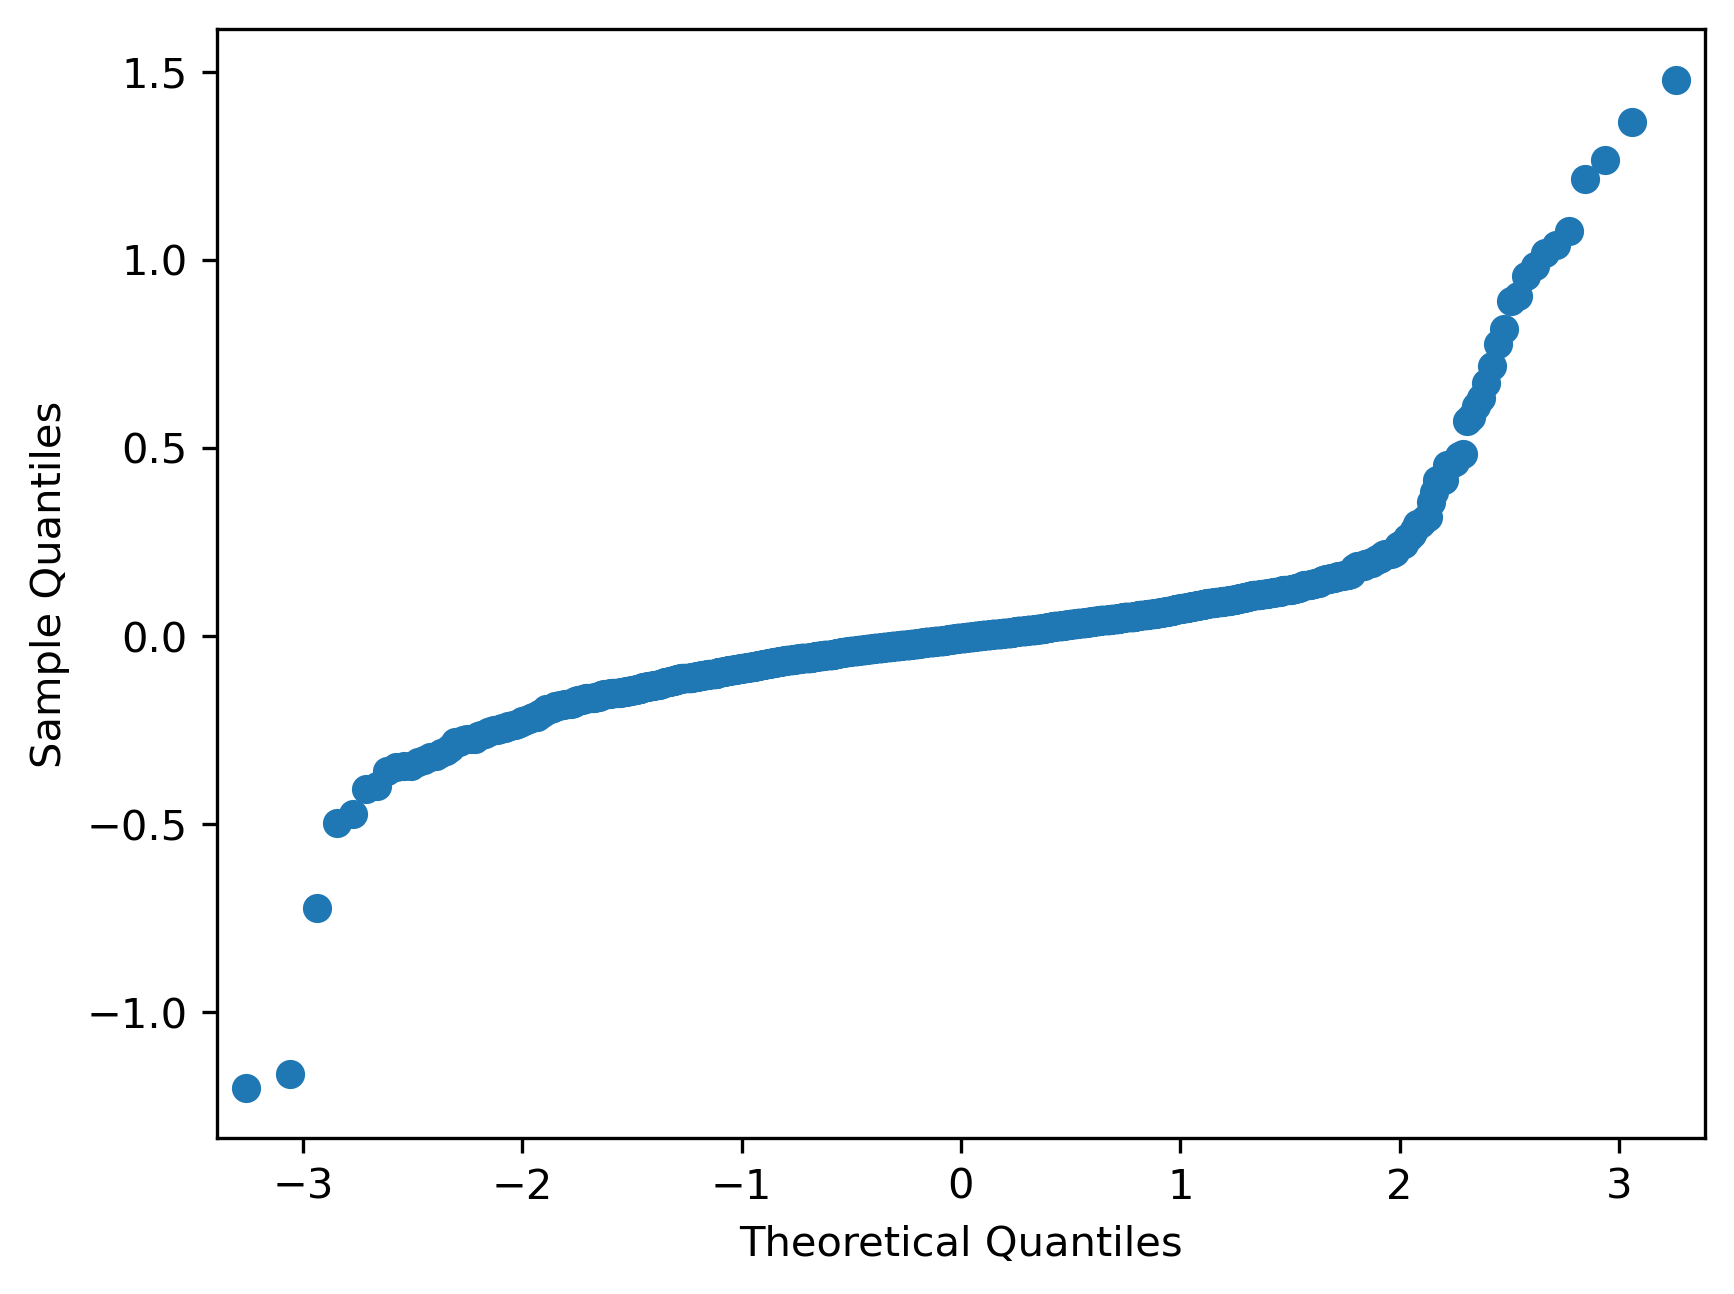

In [246]:
sm.qqplot(residuals)
plt.show()

##### From the qq plot, I think the residuals somewhat follow a gaussian distribution, but there are outliers. I suspect that the outliers might due to telescope mulfunction or some measurement failures. 

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

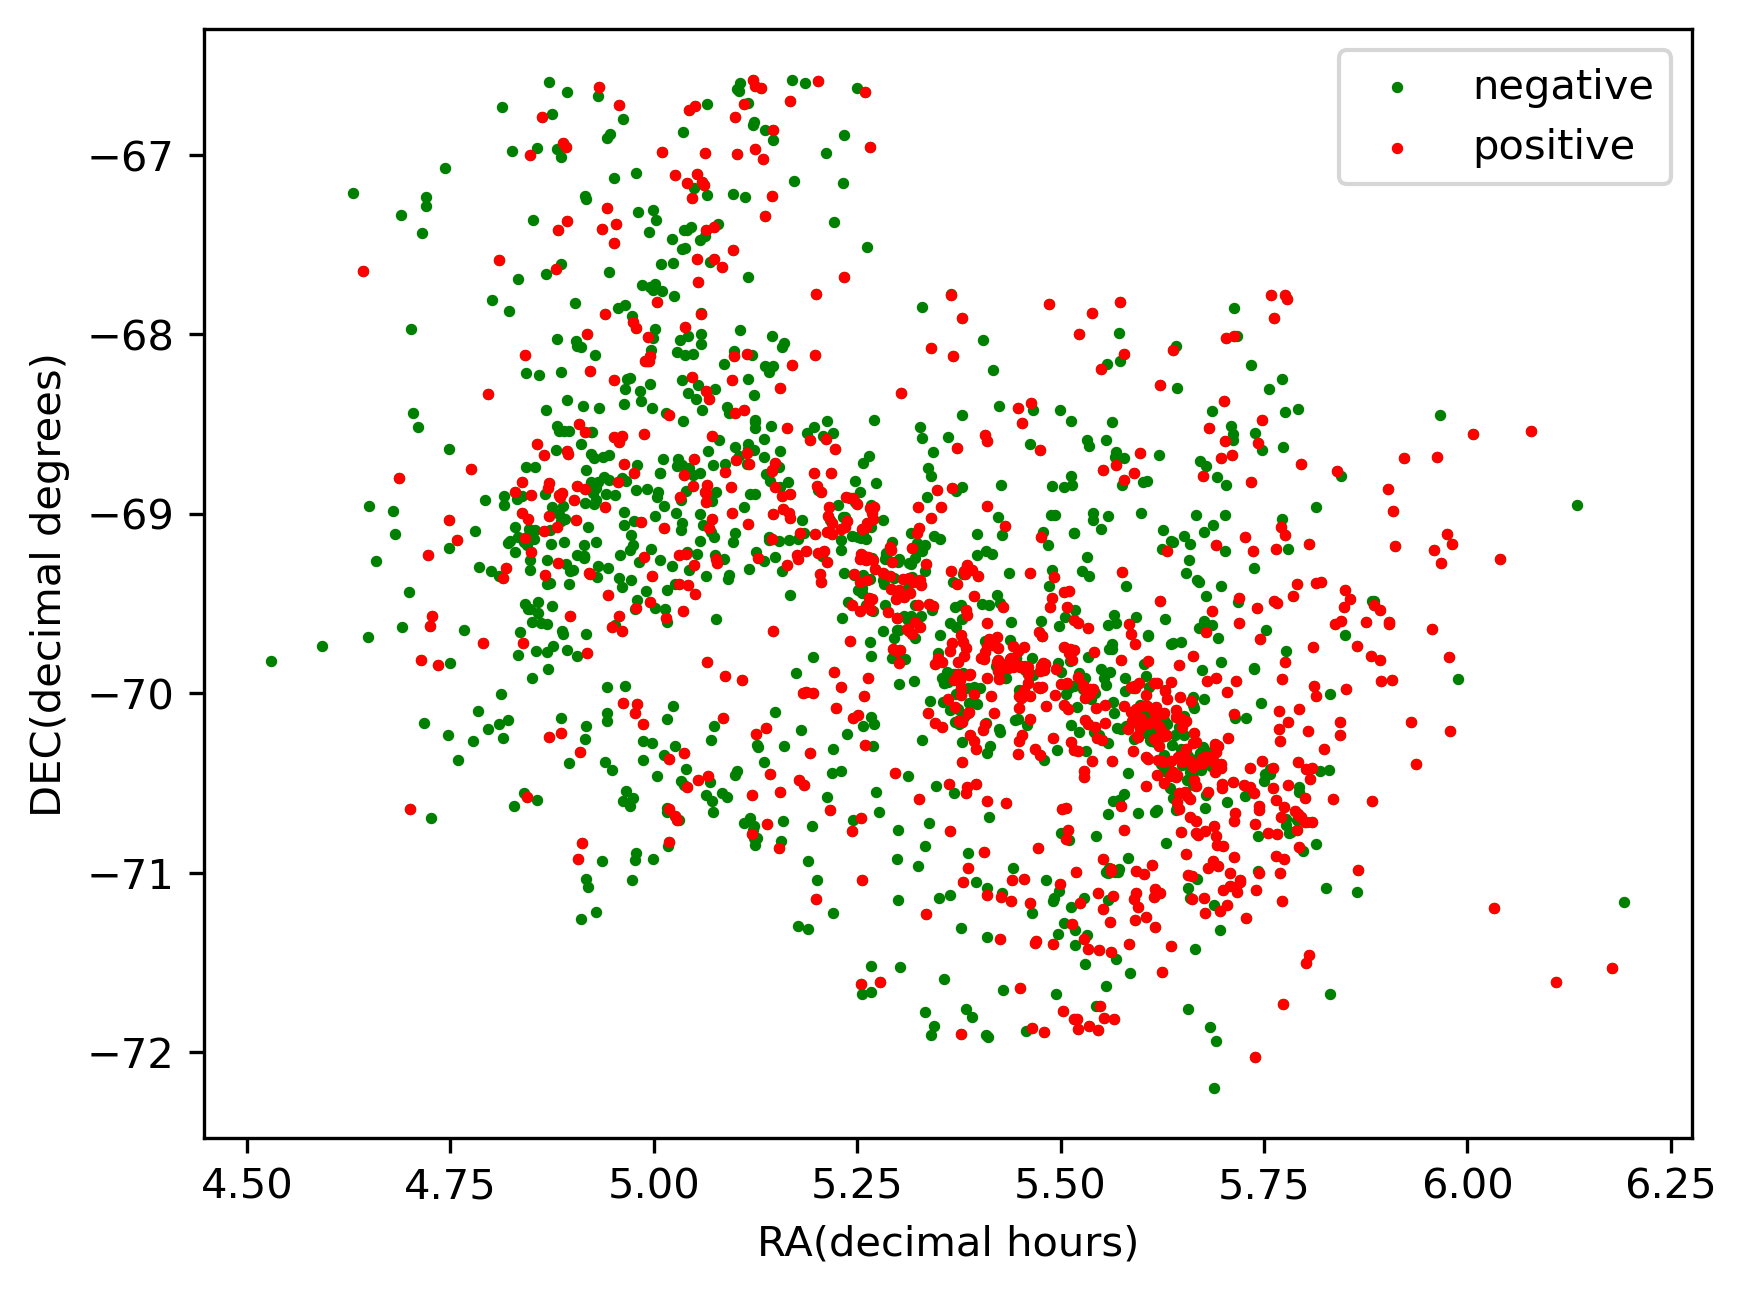

In [284]:
ra = np.array(LMC_f['RA0'])
dec = np.array(LMC_f['Decl0'])
index_positive = np.where(residuals>0)[0]
plt.scatter(ra,dec,color = 'green',label = 'negative',s=3)
plt.scatter(ra[index_positive],dec[index_positive],color = 'red',label = 'positive',s=3)
plt.xlabel('RA(decimal hours)')
plt.ylabel('DEC(decimal degrees)')
plt.legend()
plt.show()

Finally, plot the residuals against the fitted W values, and just to anticipate the next homework assignment, also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

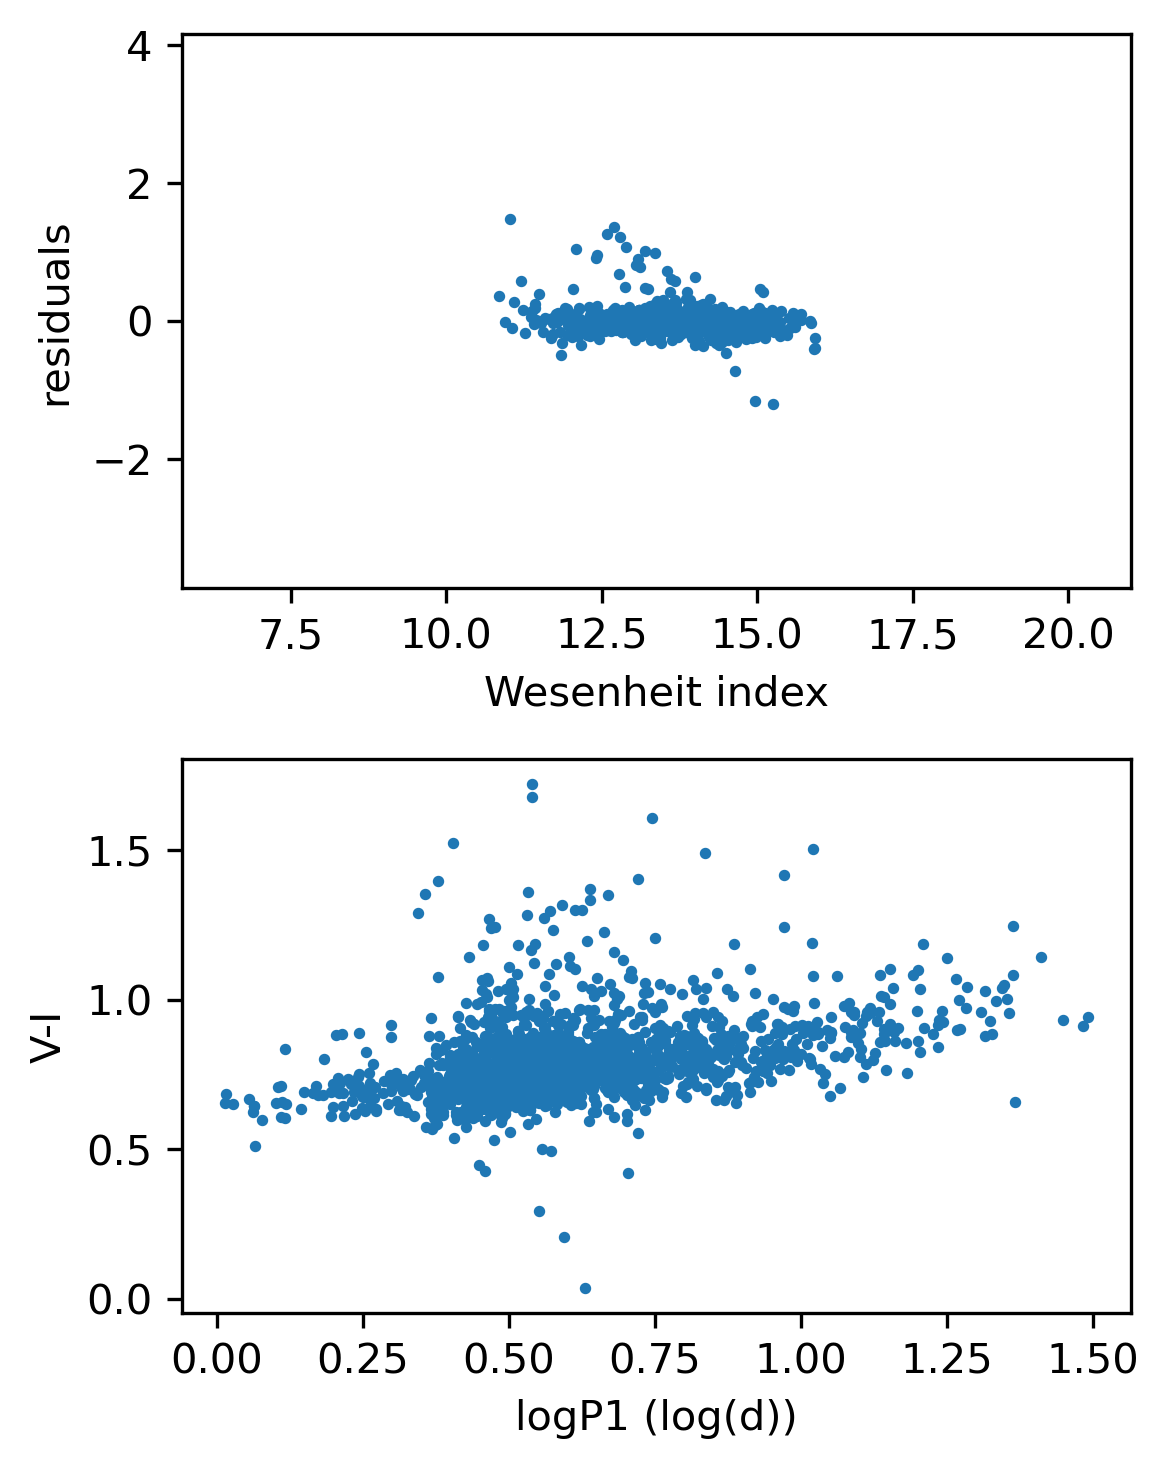

In [286]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(211)
ax.scatter(y,residuals,s=3)
ax.set_xlabel('Wesenheit index')
ax.set_ylabel('residuals')

ax.margins(1)  

V_I = np.array(LMC_f['VI'])
ax1 = fig.add_subplot(212)
ax1.scatter(x,V_I,s=3)
ax1.set_xlabel('logP1 (log(d))')
ax1.set_ylabel('V-I')
fig.tight_layout()
plt.show()

##### From the residuals vs W plot, you can kind of see that the residuals that are larger than 0.2 mostly have the W index smaller than 14. While the residuals that are smaller than -0.2 mostly have W index larger than 14. And in the V-I vs logP1 plot, there seems to be a linear relationship between the two quantities. 

In [294]:
y = np.array(LMC_1['W'])
x = np.array(LMC_1['logP1'])

In [295]:
minimum = optimize.fmin(Huber_loss,[-2,3])
minimum

Optimization terminated successfully.
         Current function value: 14.199501
         Iterations: 58
         Function evaluations: 112


array([-3.43227298, 15.3839639 ])

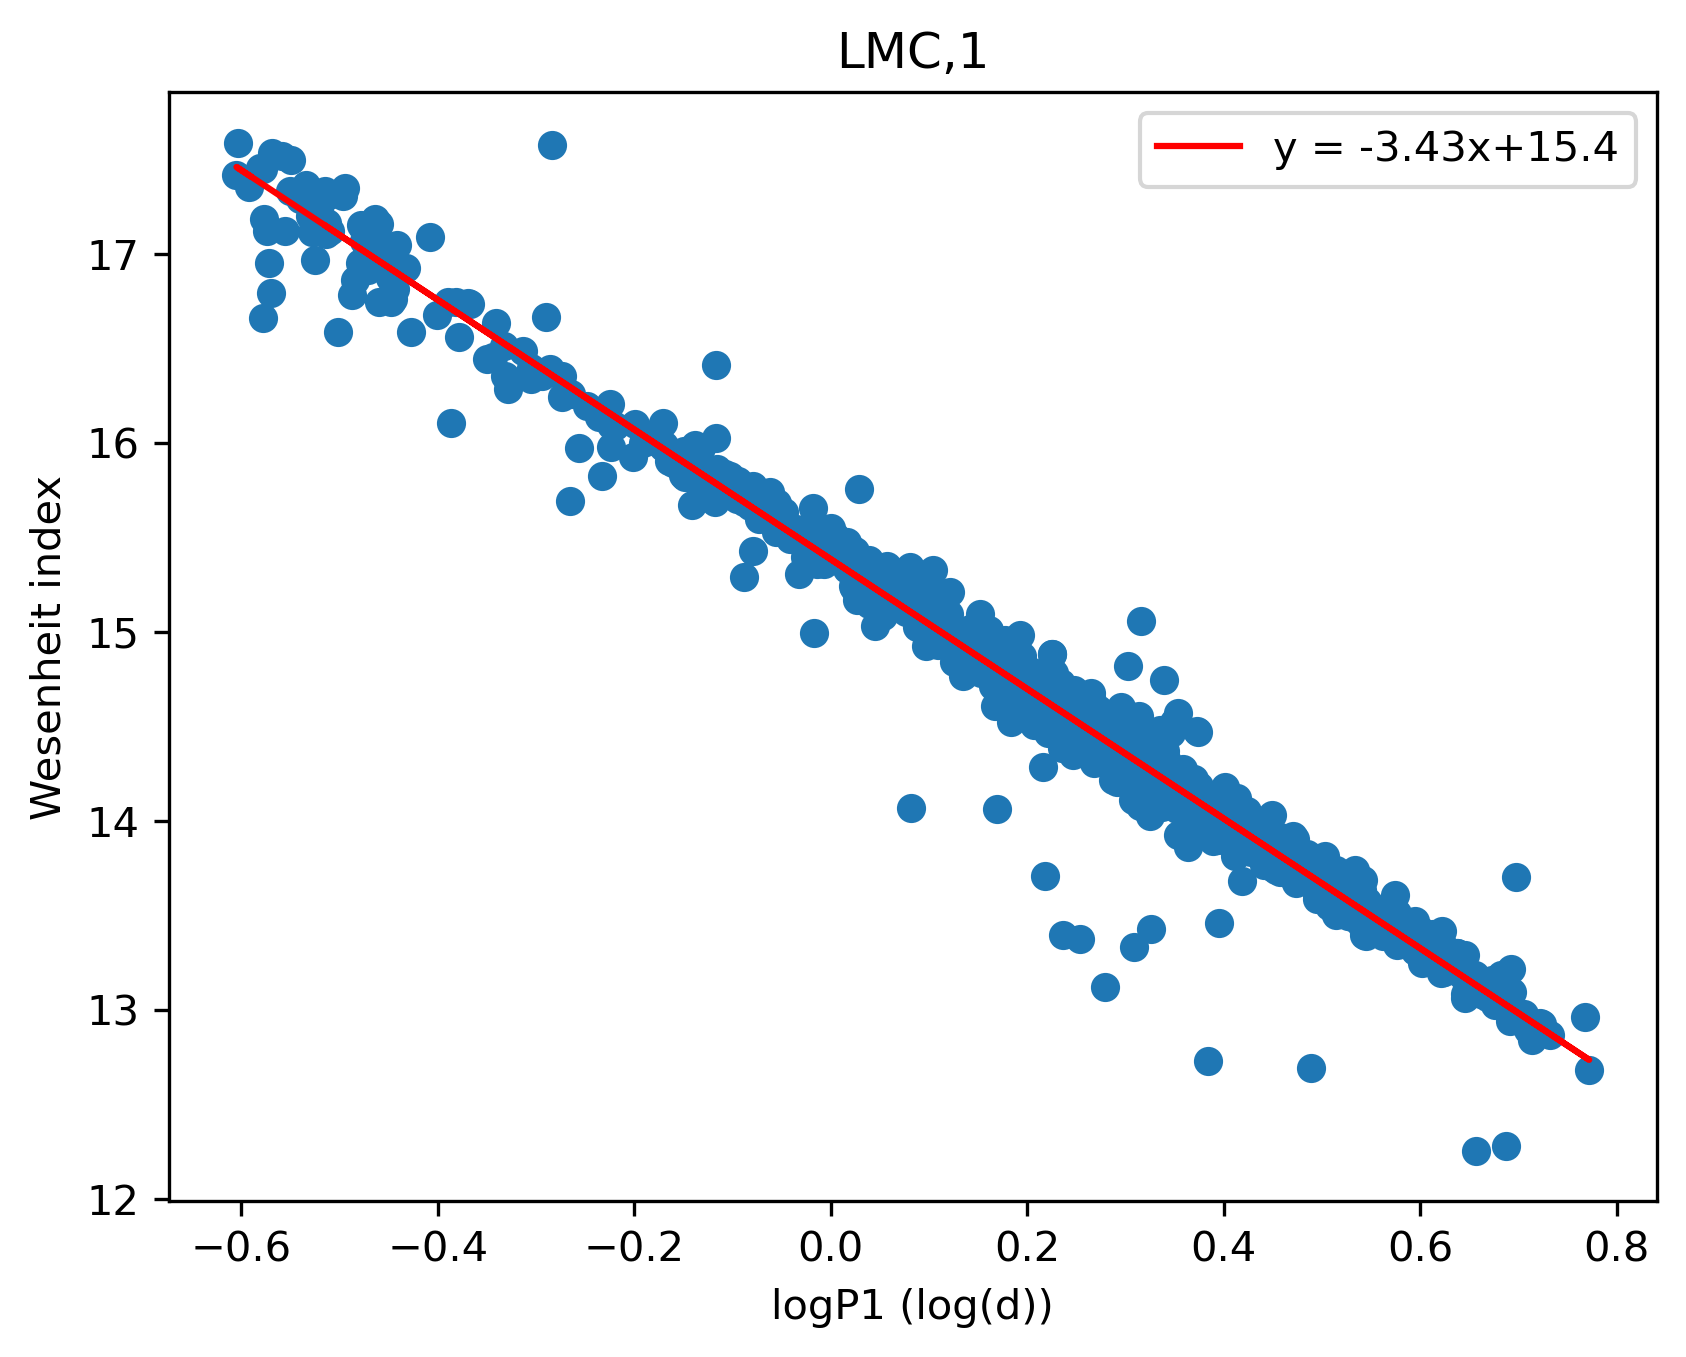

In [296]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],color = 'red',label = 'y = -3.43x+15.4')
plt.title('LMC,1')
plt.xlabel('logP1 (log(d))')
plt.ylabel('Wesenheit index')
plt.legend()
plt.show()

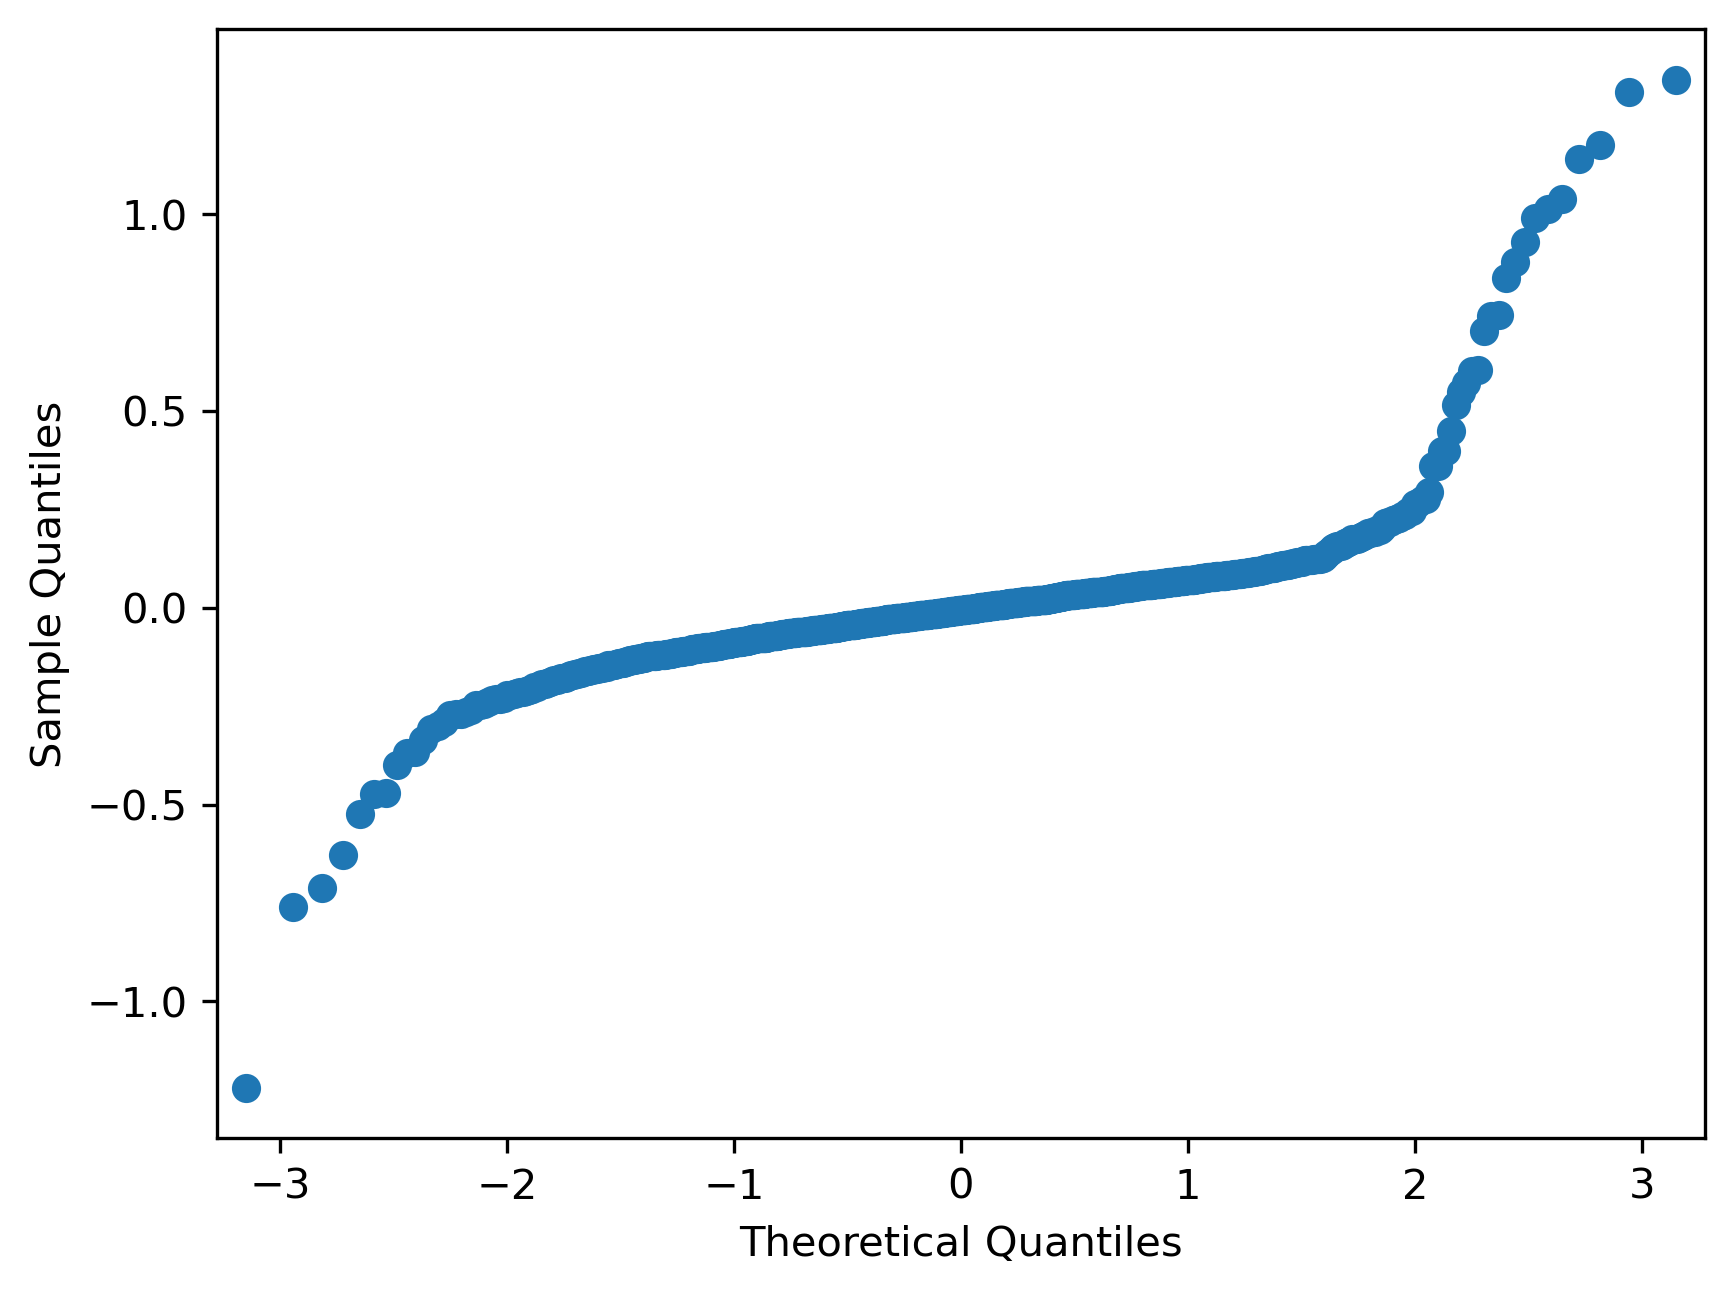

In [297]:
residuals = minimum[0]*x+minimum[1]-y
sm.qqplot(residuals)
plt.show()

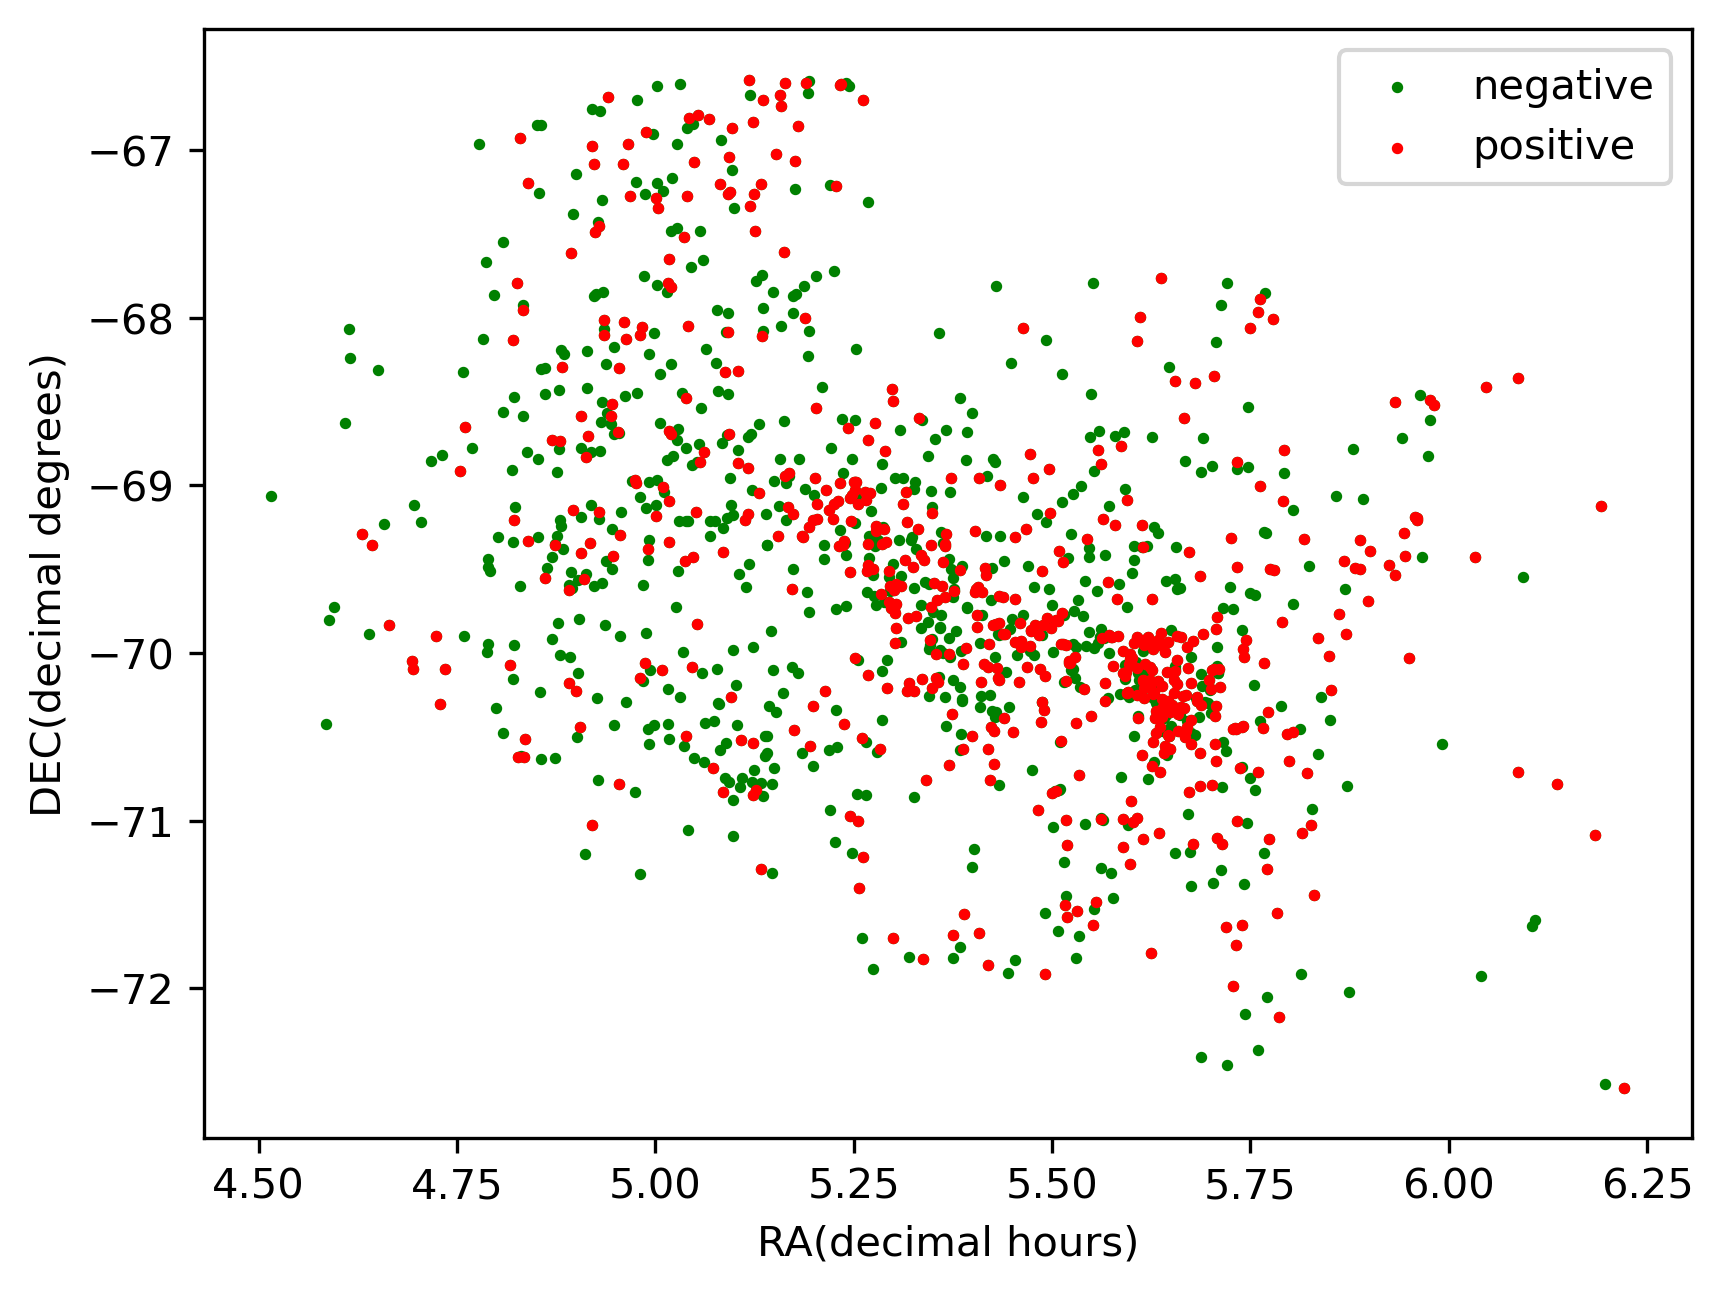

In [298]:
ra = np.array(LMC_1['RA0'])
dec = np.array(LMC_1['Decl0'])
index_positive = np.where(residuals>0)[0]
plt.scatter(ra,dec,color = 'green',label = 'negative',s=3)
plt.scatter(ra[index_positive],dec[index_positive],color = 'red',label = 'positive',s=3)
plt.xlabel('RA(decimal hours)')
plt.ylabel('DEC(decimal degrees)')
plt.legend()
plt.show()

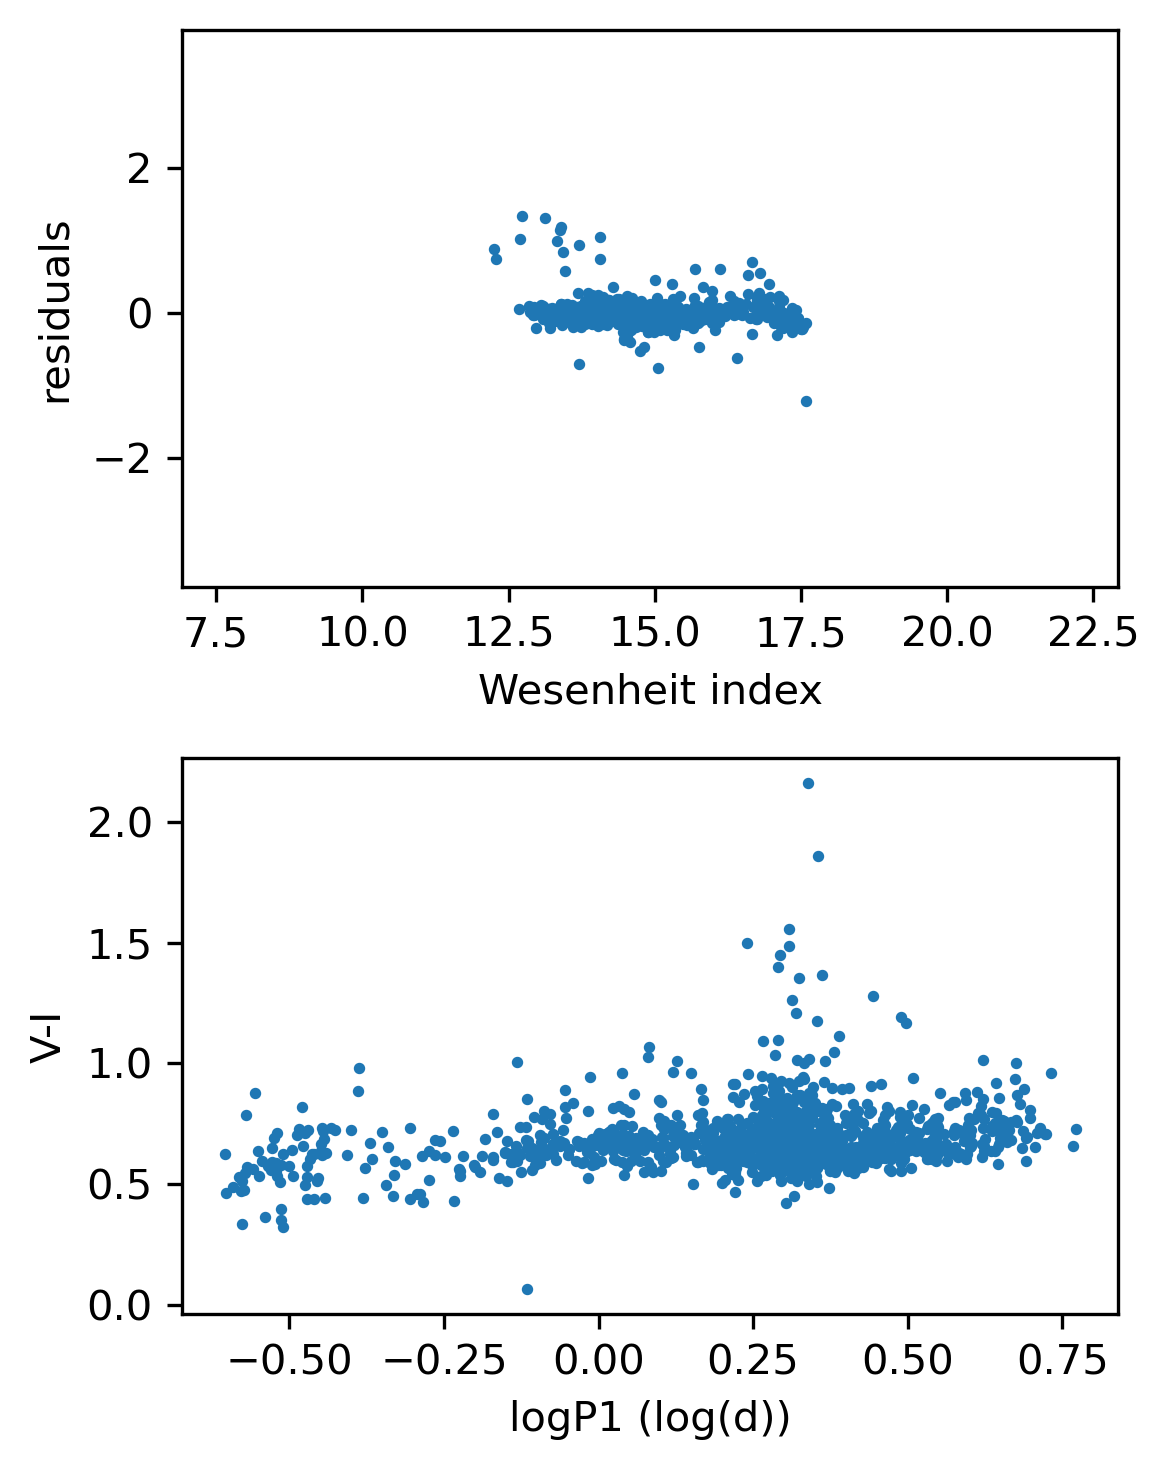

In [299]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(211)
ax.scatter(y,residuals,s=3)
ax.set_xlabel('Wesenheit index')
ax.set_ylabel('residuals')

ax.margins(1)  

V_I = np.array(LMC_1['VI'])
ax1 = fig.add_subplot(212)
ax1.scatter(x,V_I,s=3)
ax1.set_xlabel('logP1 (log(d))')
ax1.set_ylabel('V-I')
fig.tight_layout()
plt.show()

In [306]:
y = np.array(SMC_f['W'])
x = np.array(SMC_f['logP1'])

In [307]:
minimum = optimize.fmin(Huber_loss,[-2,3])
minimum

Optimization terminated successfully.
         Current function value: 60.699103
         Iterations: 58
         Function evaluations: 113


array([-3.45364287, 16.4804479 ])

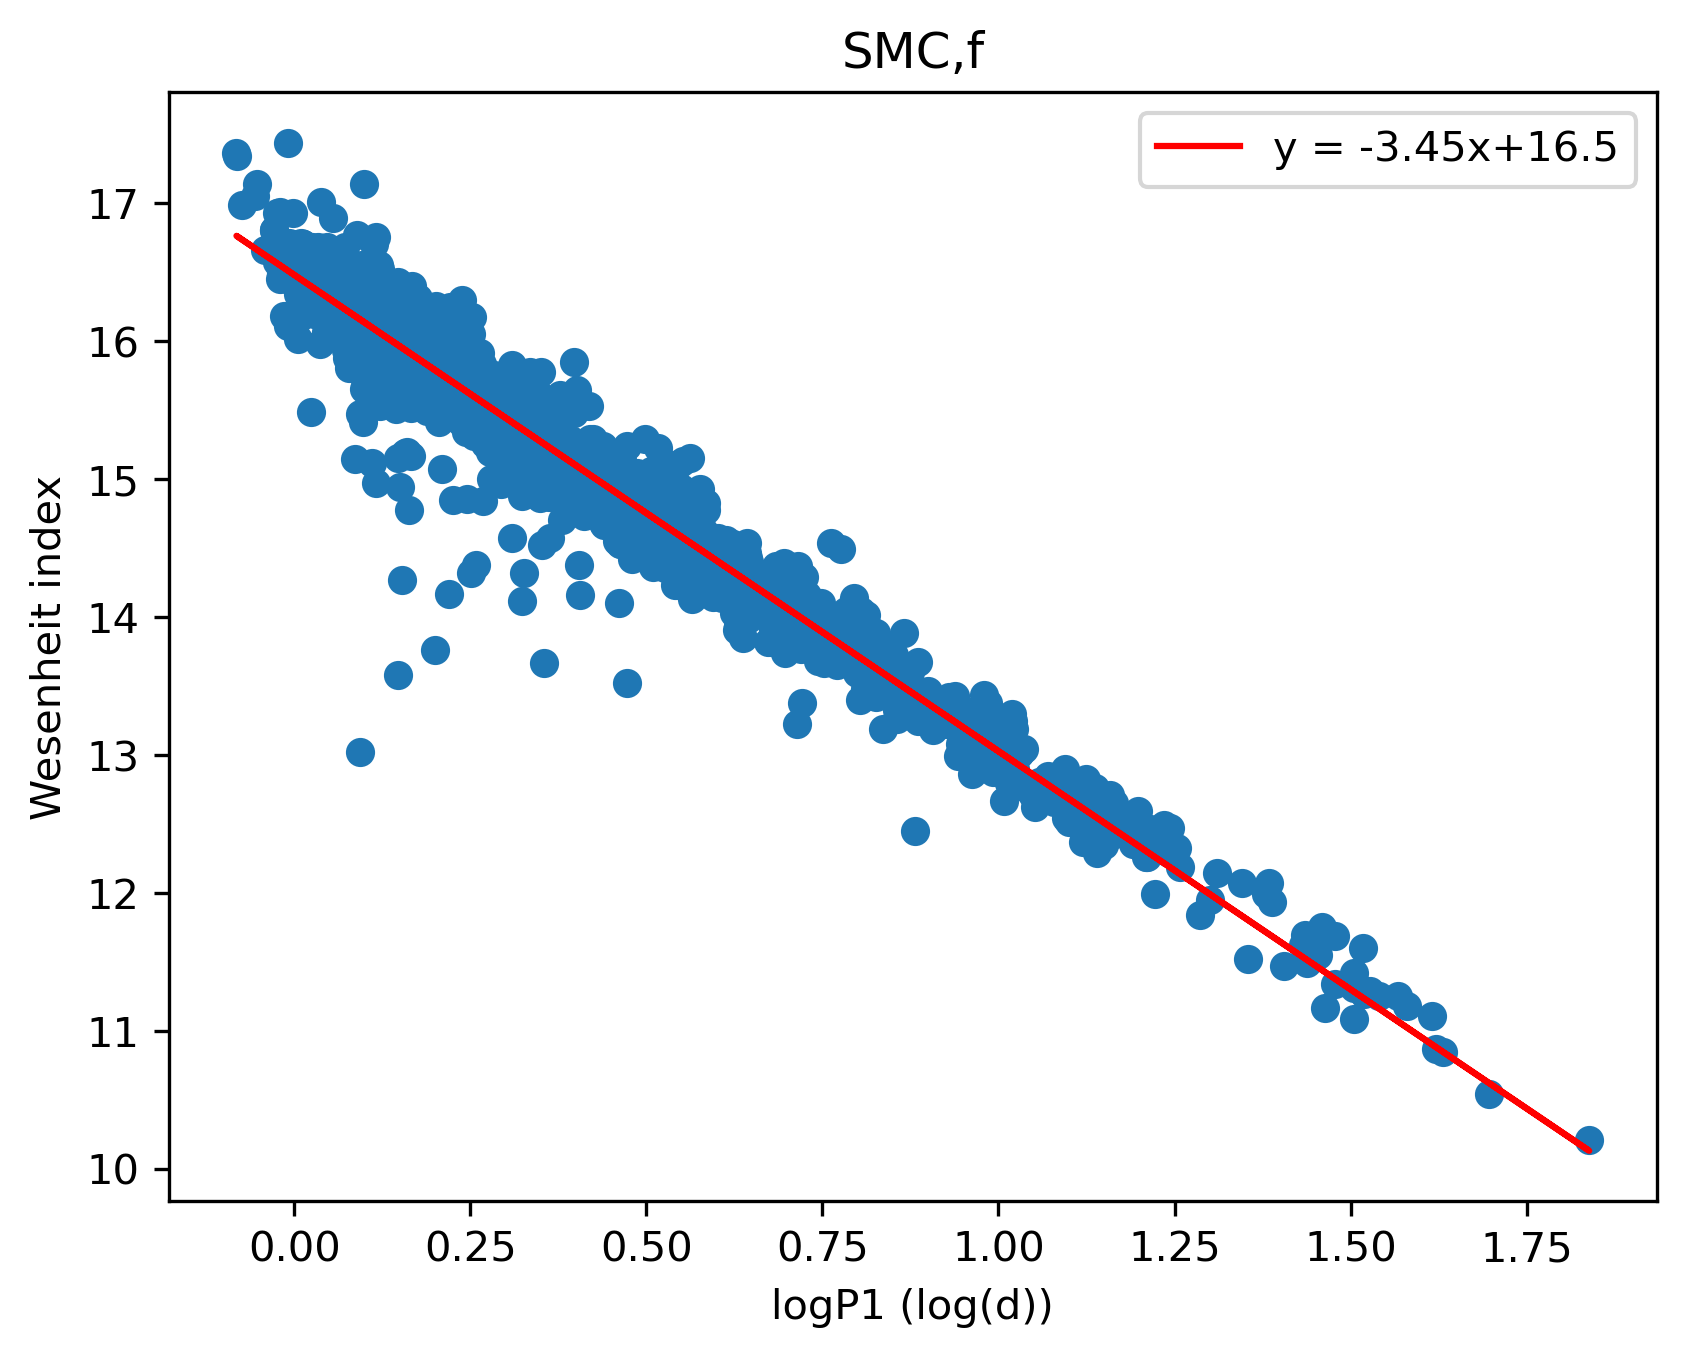

In [308]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],color = 'red',label = 'y = -3.45x+16.5')
plt.title('SMC,f')
plt.xlabel('logP1 (log(d))')
plt.ylabel('Wesenheit index')
plt.legend()
plt.show()

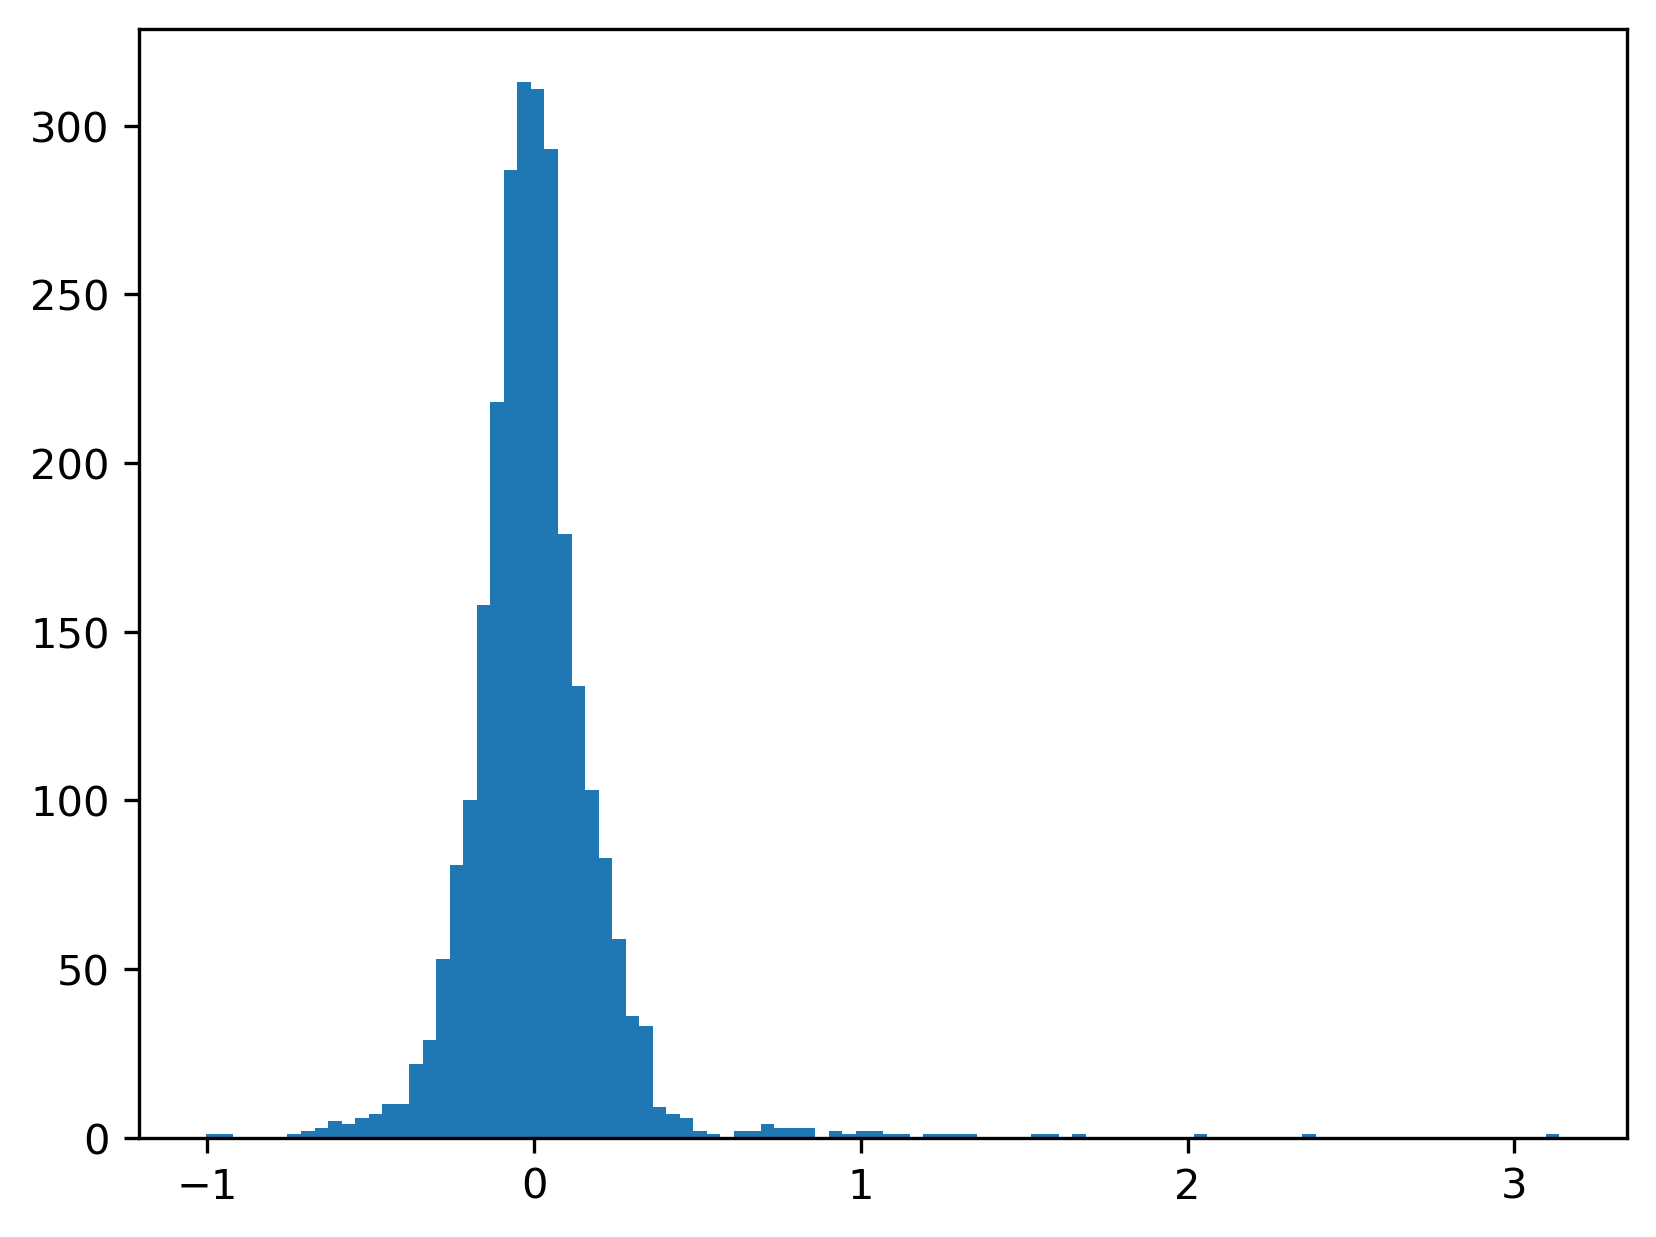

In [311]:
residuals = minimum[0]*x+minimum[1]-y
plt.hist(residuals,bins=100)
plt.show()

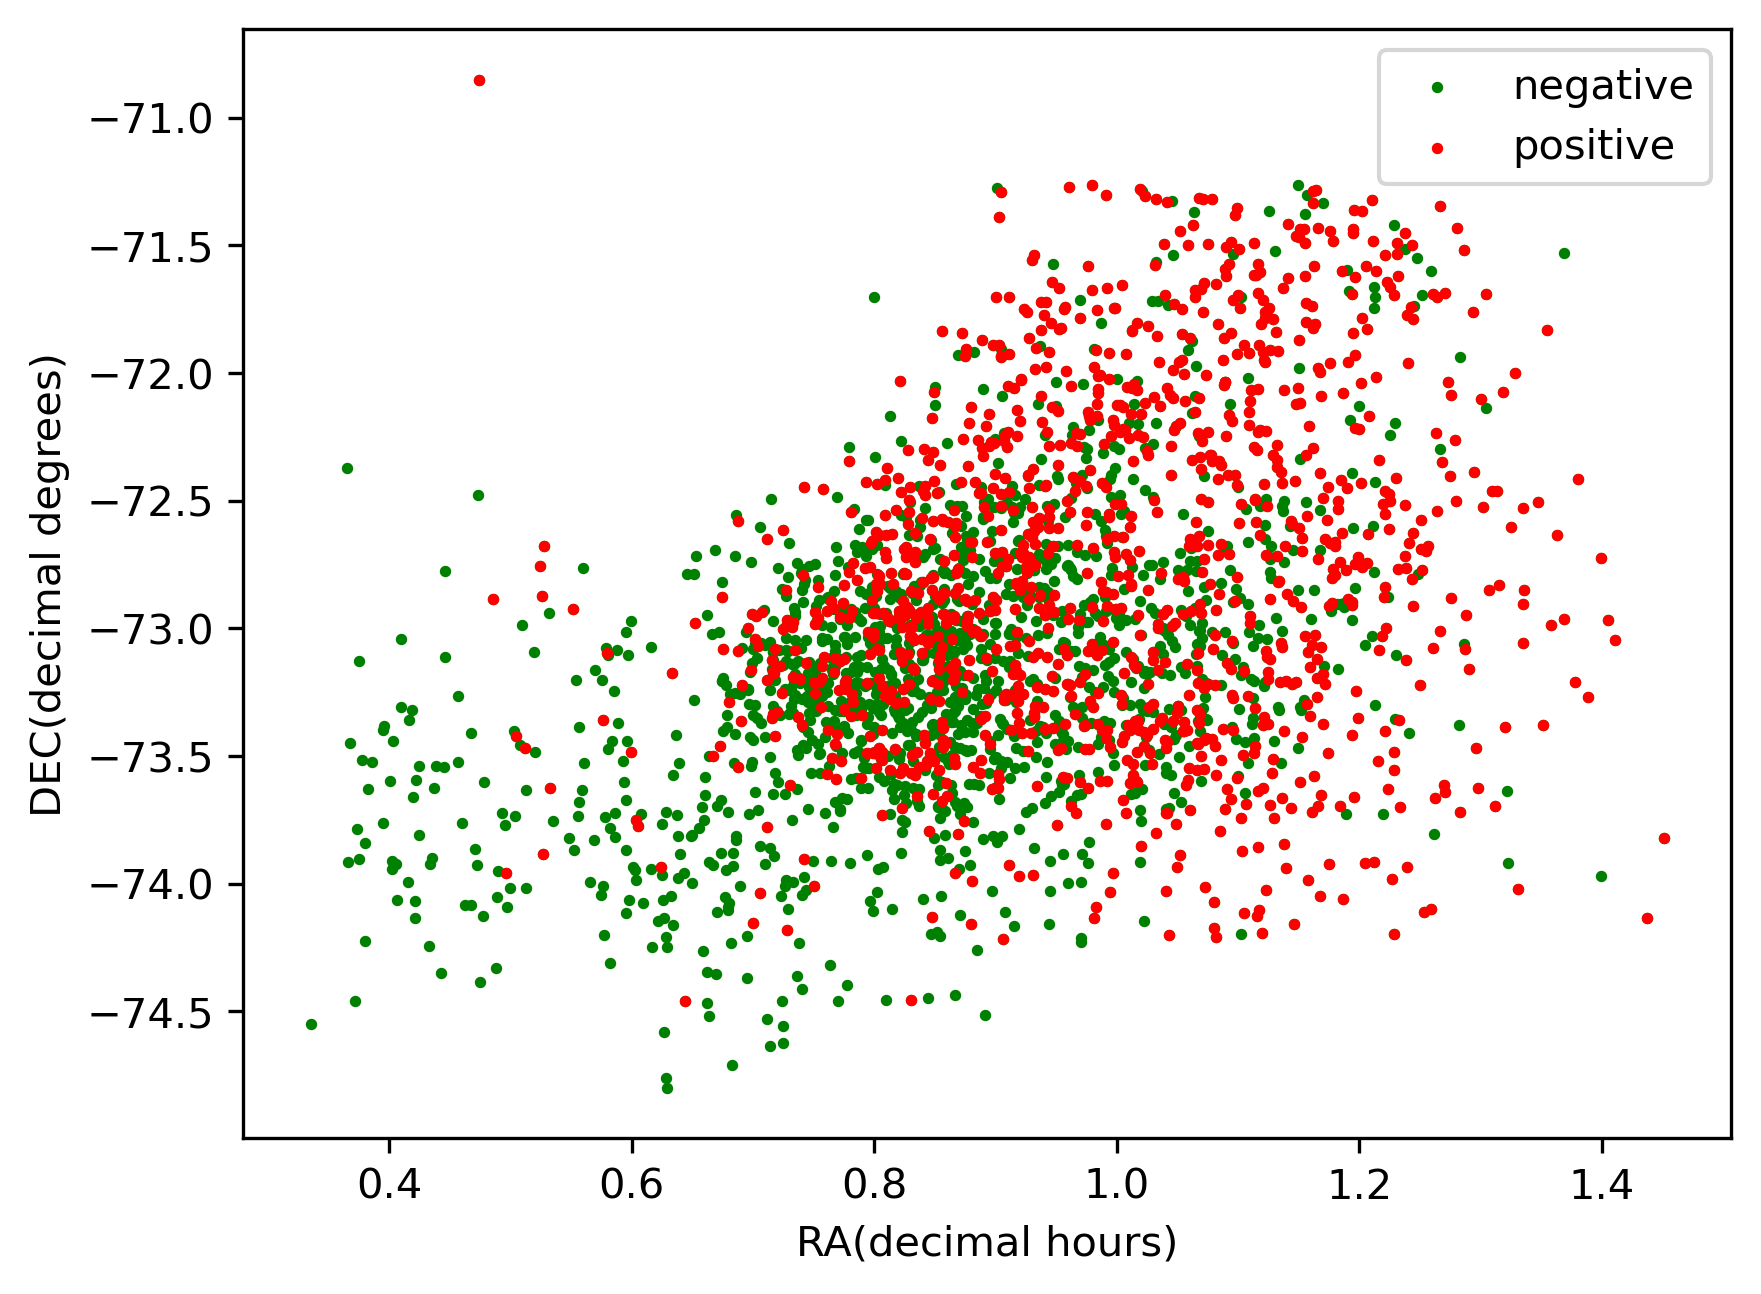

In [312]:
ra = np.array(SMC_f['RA0'])
dec = np.array(SMC_f['Decl0'])
index_positive = np.where(residuals>0)[0]
plt.scatter(ra,dec,color = 'green',label = 'negative',s=3)
plt.scatter(ra[index_positive],dec[index_positive],color = 'red',label = 'positive',s=3)
plt.xlabel('RA(decimal hours)')
plt.ylabel('DEC(decimal degrees)')
plt.legend()
plt.show()

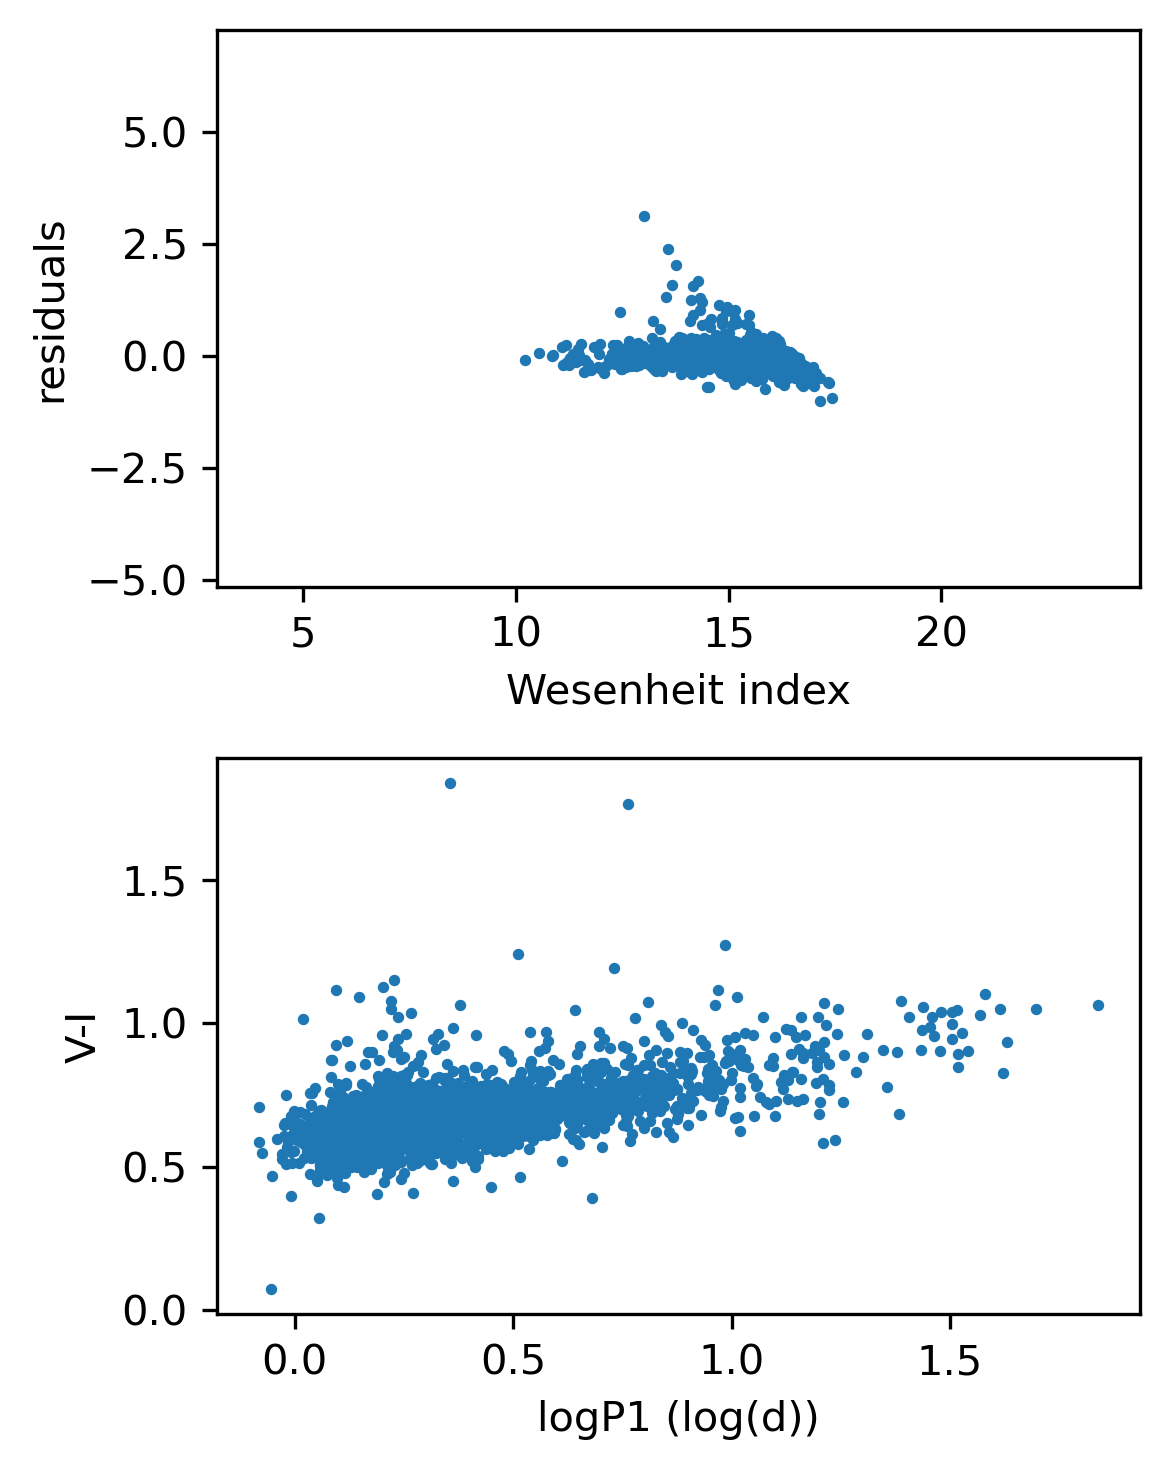

In [313]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(211)
ax.scatter(y,residuals,s=3)
ax.set_xlabel('Wesenheit index')
ax.set_ylabel('residuals')

ax.margins(1)  

V_I = np.array(SMC_f['VI'])
ax1 = fig.add_subplot(212)
ax1.scatter(x,V_I,s=3)
ax1.set_xlabel('logP1 (log(d))')
ax1.set_ylabel('V-I')
fig.tight_layout()
plt.show()

In [314]:
y = np.array(SMC_1['W'])
x = np.array(SMC_1['logP1'])

In [315]:
minimum = optimize.fmin(Huber_loss,[-2,3])
minimum

Optimization terminated successfully.
         Current function value: 41.803642
         Iterations: 63
         Function evaluations: 119


array([-3.61544501, 15.96236325])

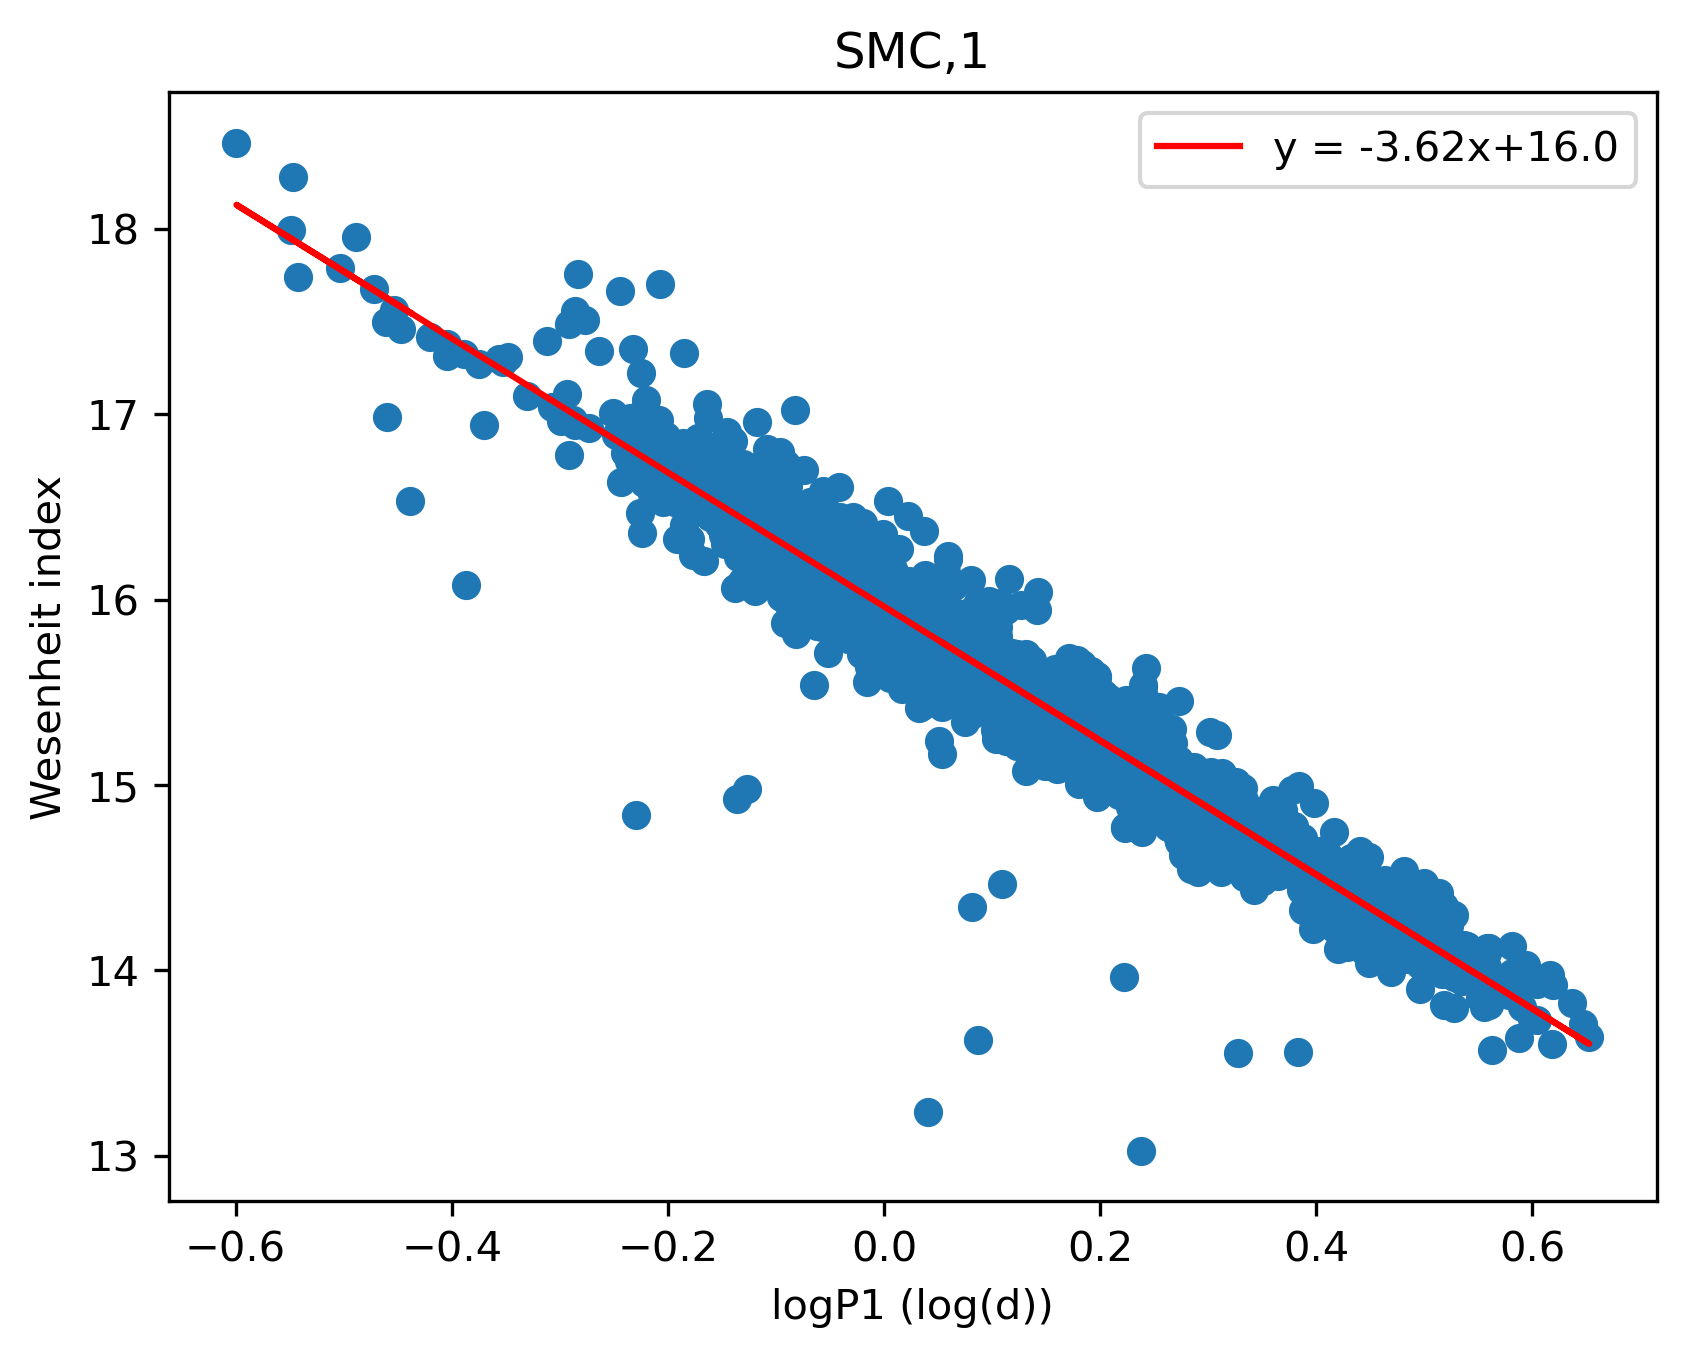

In [316]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],color = 'red',label = 'y = -3.62x+16.0')
plt.title('SMC,1')
plt.xlabel('logP1 (log(d))')
plt.ylabel('Wesenheit index')
plt.legend()
plt.show()

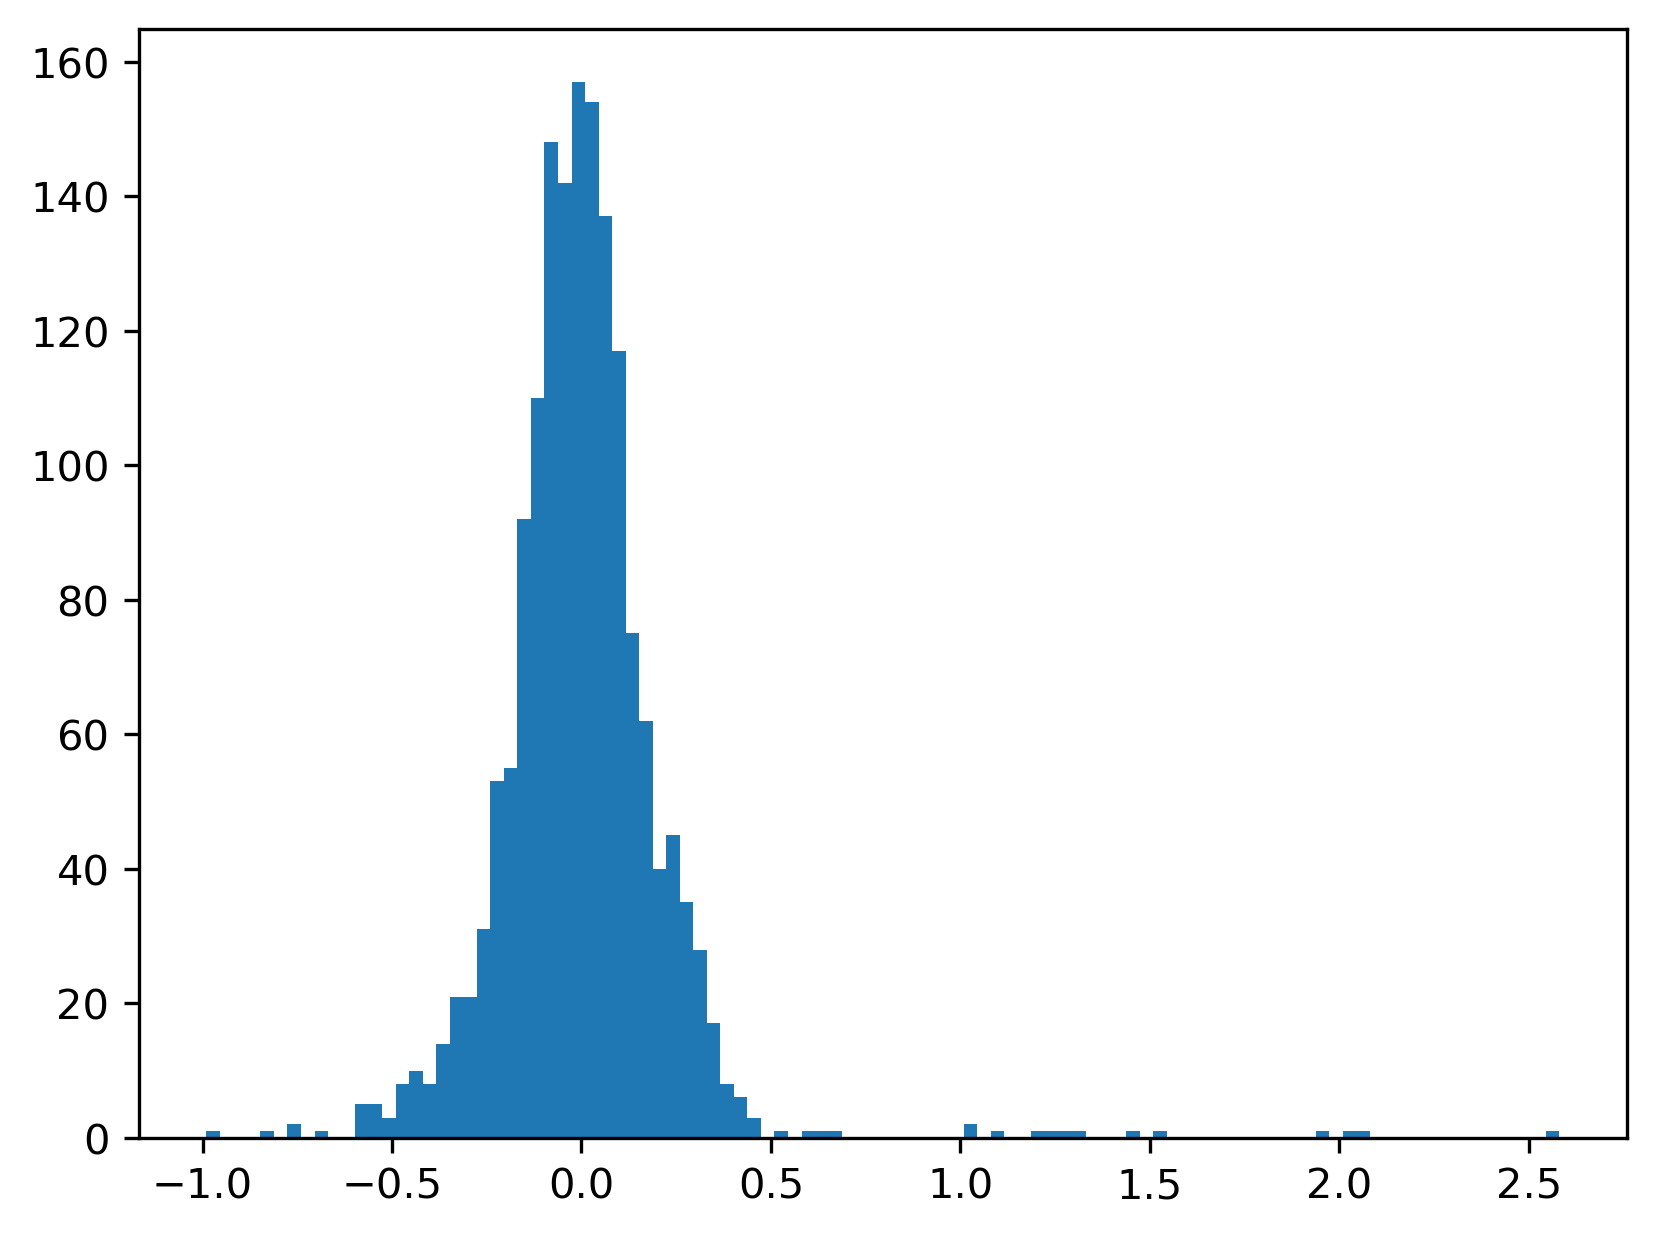

In [317]:
residuals = minimum[0]*x+minimum[1]-y
plt.hist(residuals,bins=100)
plt.show()

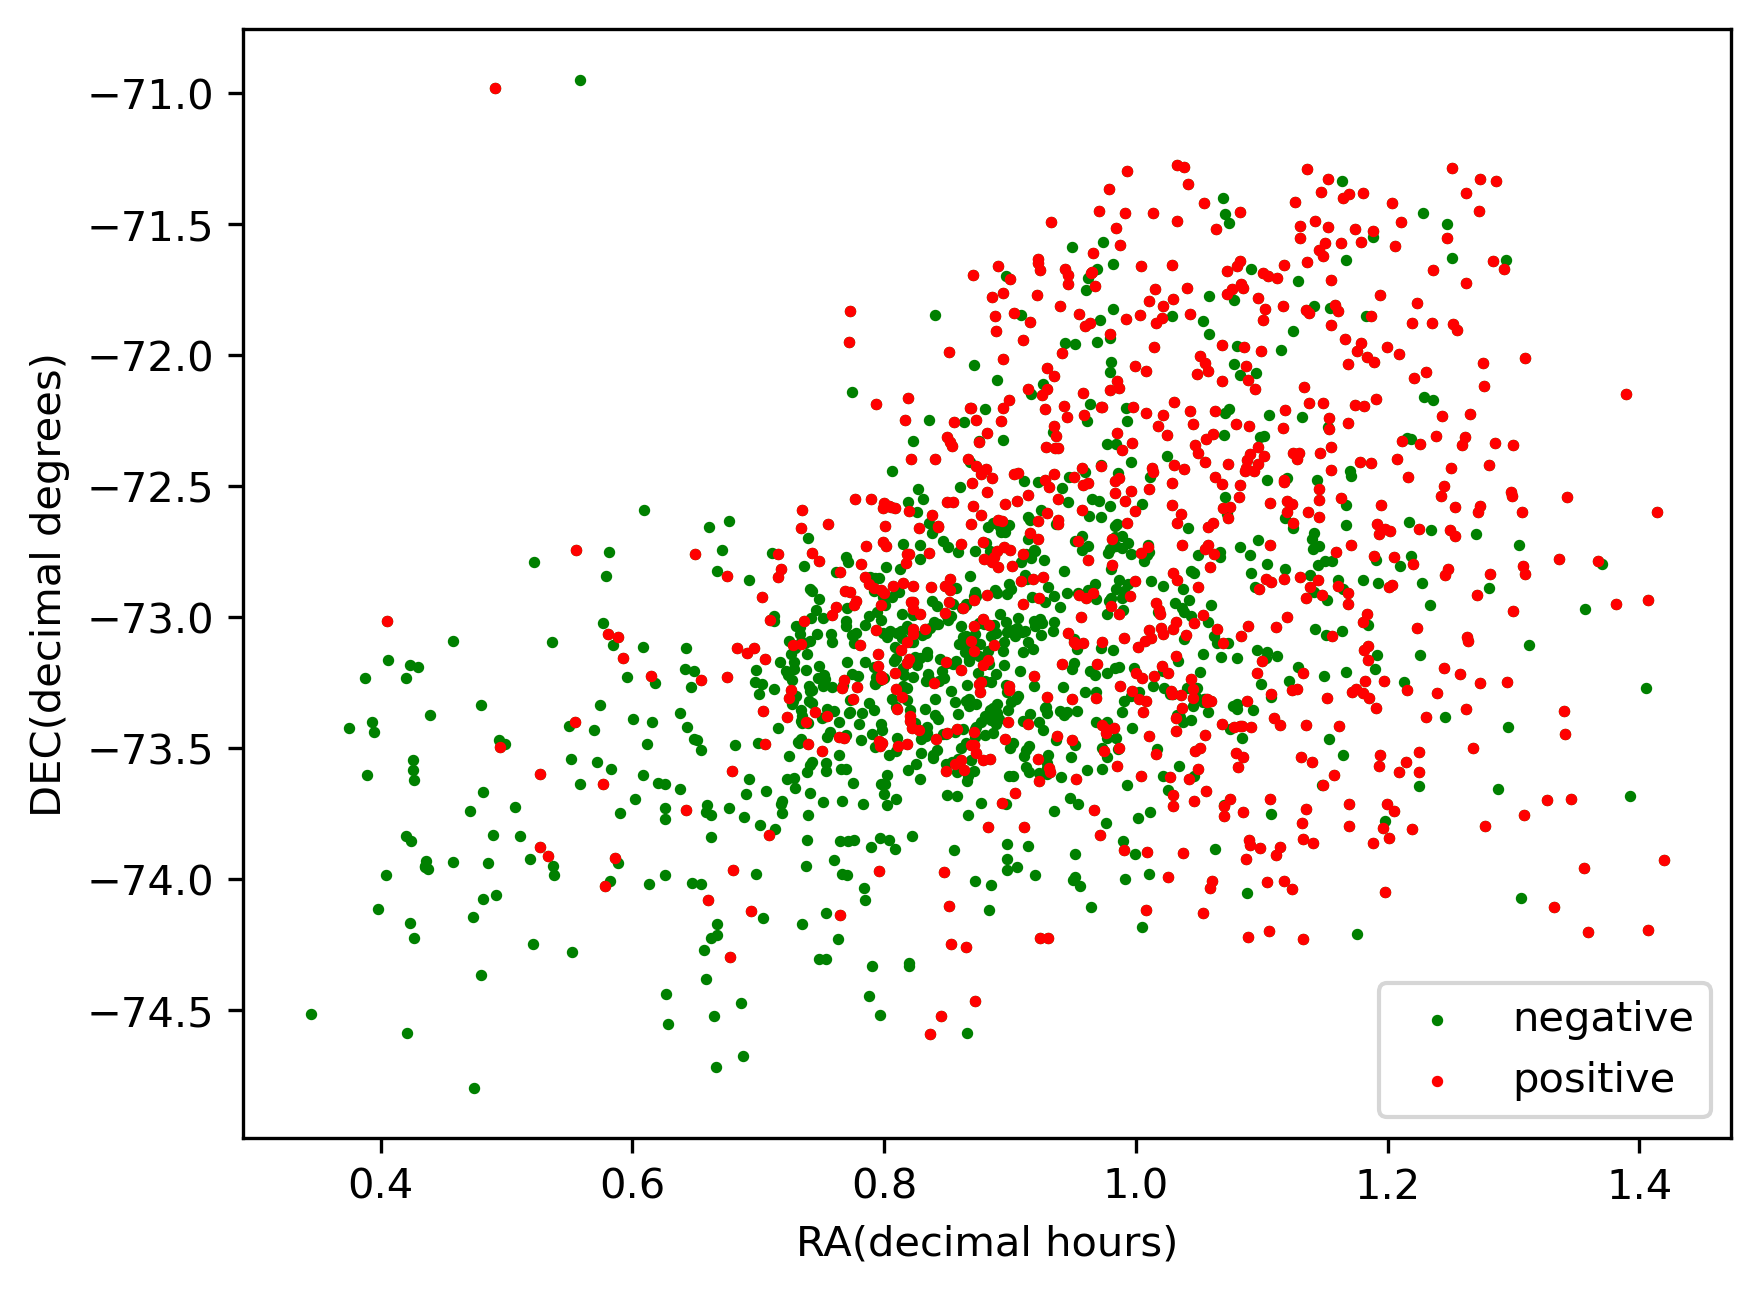

In [318]:
ra = np.array(SMC_1['RA0'])
dec = np.array(SMC_1['Decl0'])
index_positive = np.where(residuals>0)[0]
plt.scatter(ra,dec,color = 'green',label = 'negative',s=3)
plt.scatter(ra[index_positive],dec[index_positive],color = 'red',label = 'positive',s=3)
plt.xlabel('RA(decimal hours)')
plt.ylabel('DEC(decimal degrees)')
plt.legend()
plt.show()

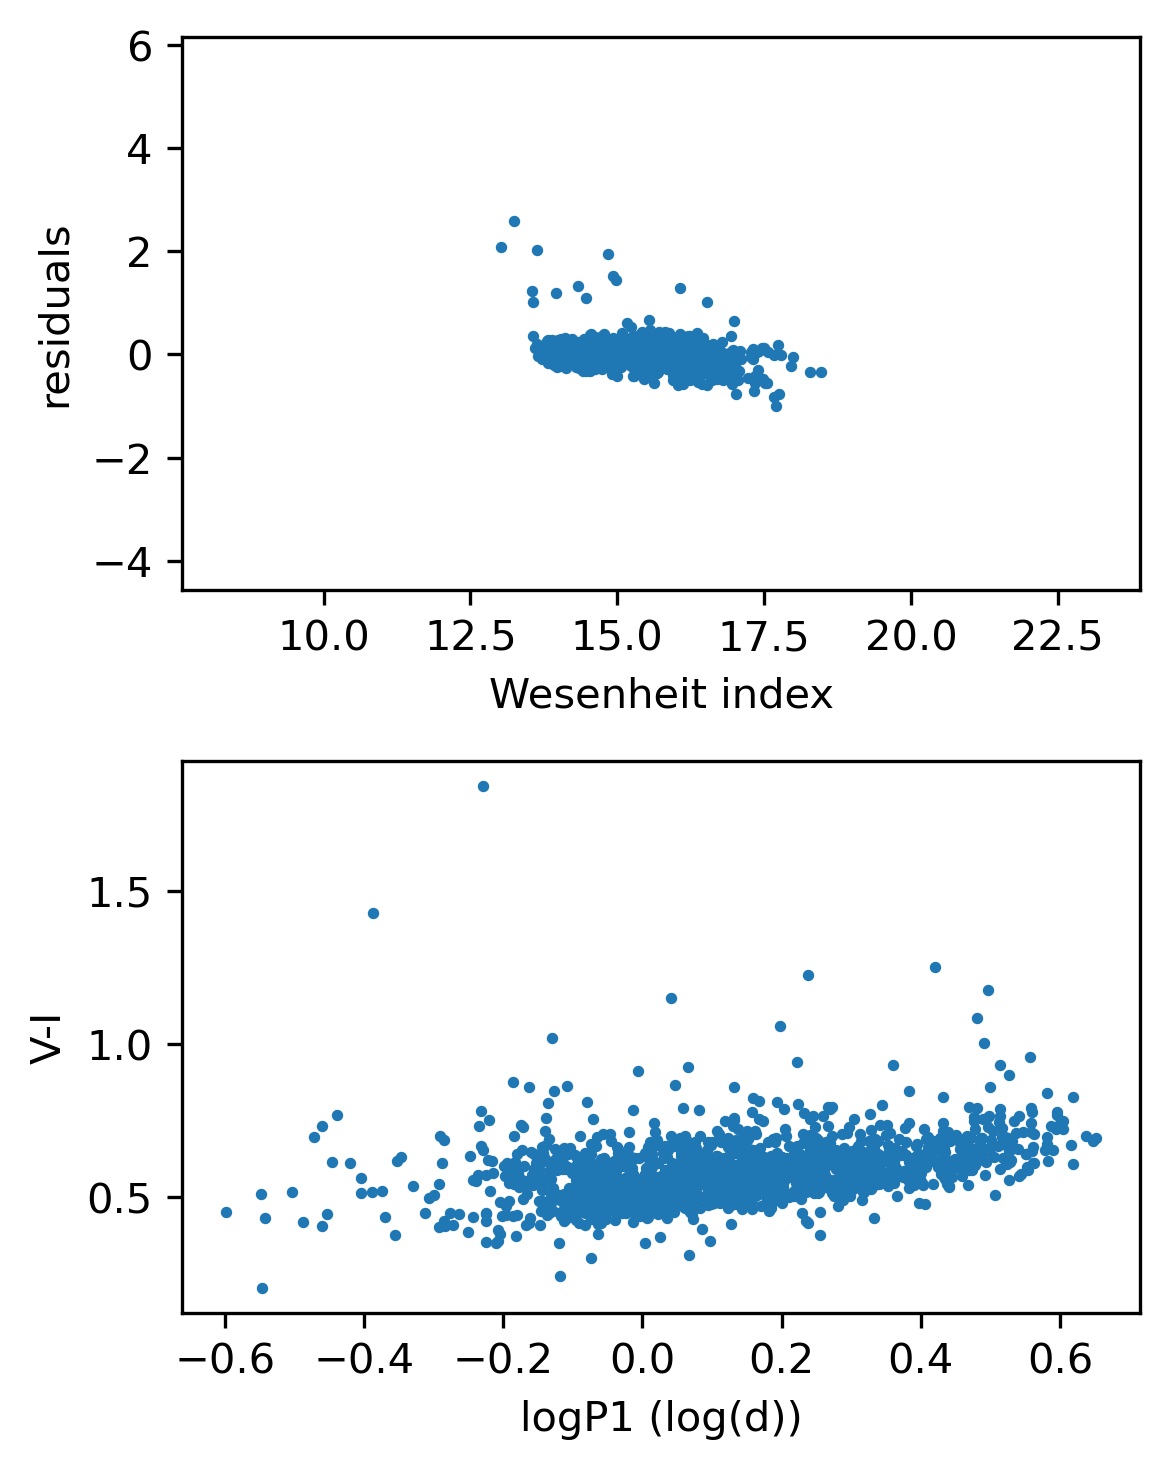

In [319]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(211)
ax.scatter(y,residuals,s=3)
ax.set_xlabel('Wesenheit index')
ax.set_ylabel('residuals')

ax.margins(1)  

V_I = np.array(SMC_1['VI'])
ax1 = fig.add_subplot(212)
ax1.scatter(x,V_I,s=3)
ax1.set_xlabel('logP1 (log(d))')
ax1.set_ylabel('V-I')
fig.tight_layout()
plt.show()